In [1]:
# suppress enjoying warnings from seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

from collections import Counter

# for fiding file names
from pathlib import Path
from glob import glob
import gc

# data processing libraries
import polars as pl
import numpy as np
import pandas as pd

# for visualizing data
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn functions
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
# for validating models
from sklearn.metrics import roc_auc_score, roc_curve

# LightGBM modeling
import lightgbm as lgb

# define default colors for plots in notebook
from matplotlib import cycler
from matplotlib.colors import LinearSegmentedColormap
COLORS = ["#068D9D", "#53599A", "#607BB0", "#6D9DC5", "#77BECF", "#80DED9", "#AEECEF"]
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', axisbelow=True, grid=True, prop_cycle=cycler('color', COLORS))

In [2]:
# project CONSTANTS
# ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability")
DRIVE = "I:"
USERNAME = os.environ['USERNAME']
ROOT = Path(DRIVE).joinpath(USERNAME, "data", "Home Credit - Credit Risk Model Stability")
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"
SEED = 2024

In [3]:
BAR_PLOT_KWARGS = {
    'linewidth': 1.0,
    'edgecolor': "0.5",
    'facecolor': (86/255, 135/255, 160/255, 0.8),
}


class Pipeline:
    """
    Helper class taken from notebook:
    https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm
    """
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
                # df = df.with_columns(pl.col(col).cast(pl.Categorical))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df


def get_dtype_counts(df: pl.DataFrame) -> dict:
    return Counter([str(d) for d in df.dtypes])


def plot_dtype_count(df: pl.DataFrame, filename: Path):
    counts = get_dtype_counts(df)
    fig, ax = plt.subplots(figsize=(8, 6))
    count_values = list(map(int, counts.values()))
    sns.barplot(
        y=counts.keys(),
        x=count_values, 
        orient='h',
        ax=ax,
        **BAR_PLOT_KWARGS
    )
    plt.title(f"Data Type Counts\n{filename.name}")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()


def plot_nulls(df: pl.DataFrame, filename: Path):
    nulls = df.null_count() / df.shape[0]
    nulls = nulls.to_pandas().T[0]
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.barplot(
        nulls, 
        orient='h',
        ax=ax,
        **BAR_PLOT_KWARGS
    )
    plt.title(f"Null Counts\n{filename.name}")
    plt.xlabel("% Nulls")
    plt.tight_layout()
    plt.show()


def plot_cardinality(df: pl.DataFrame, filename: Path):
    card = {}
    for col in df.select(pl.col(pl.Utf8)).columns:
        v = round(df.select(pl.col(col)).n_unique() / df.shape[0], 6)
        card[col] = v
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(
        y=card.keys(),
        x=card.values(), 
        orient='h',
        ax=ax,
        **BAR_PLOT_KWARGS
    )
    plt.title(f"Cardinality\n{filename.name}")
    plt.xlabel("% Unique")
    plt.tight_layout()
    plt.show()

In [4]:
files = list(TRAIN_DIR.glob("*credit_bureau_*parquet"))
filename = files[2]

In [5]:
df = pl.read_parquet(filename)#.pipe(Pipeline.set_table_dtypes)
df.head()

shape: (5, 79)
┌─────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ case_id ┆ annualeffect ┆ annualeffect ┆ classificati ┆ … ┆ totaldebtove ┆ totaldebtove ┆ totaloutstan ┆ totaloutstan │
│ ---     ┆ iverate_199L ┆ iverate_63L  ┆ onofcontr_13 ┆   ┆ rduevalue_17 ┆ rduevalue_71 ┆ ddebtvalue_3 ┆ ddebtvalue_6 │
│ i64     ┆ ---          ┆ ---          ┆ M            ┆   ┆ 8A           ┆ 8A           ┆ 9A           ┆ 68A          │
│         ┆ f64          ┆ f64          ┆ ---          ┆   ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│         ┆              ┆              ┆ str          ┆   ┆ f64          ┆ f64          ┆ f64          ┆ f64          │
╞═════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 40626   ┆ 0.69         ┆ null         ┆ a55475b1     ┆ … ┆ null         ┆ null         ┆ null         ┆ null         │
│ 40626   ┆ 0.69         ┆ null         ┆ a55475b1     ┆ … ┆ null         ┆ null         ┆ null         ┆ null         │
│ 40626   ┆ 38.3         ┆ null         ┆ ea6782cc     ┆ … ┆ null         ┆ null         ┆ null         ┆ null         │
│ 40626   ┆ 68.3         ┆ null         ┆ ea6782cc     ┆ … ┆ null         ┆ null         ┆ null         ┆ null         │
│ 40626   ┆ 96.3         ┆ null         ┆ a55475b1     ┆ … ┆ null         ┆ null         ┆ null         ┆ null         │
└─────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴──────────────┴──────────────┴──────────────┘

In [6]:
# df = pd.read_parquet(filename)
# df.head()

In [7]:
df.estimated_size("mb")

2080.1972818374634

## Tax Registry Files

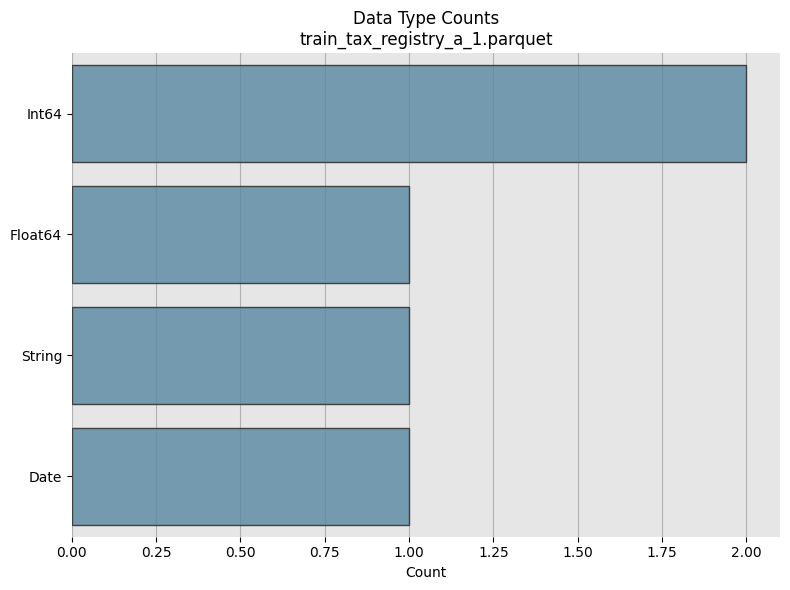

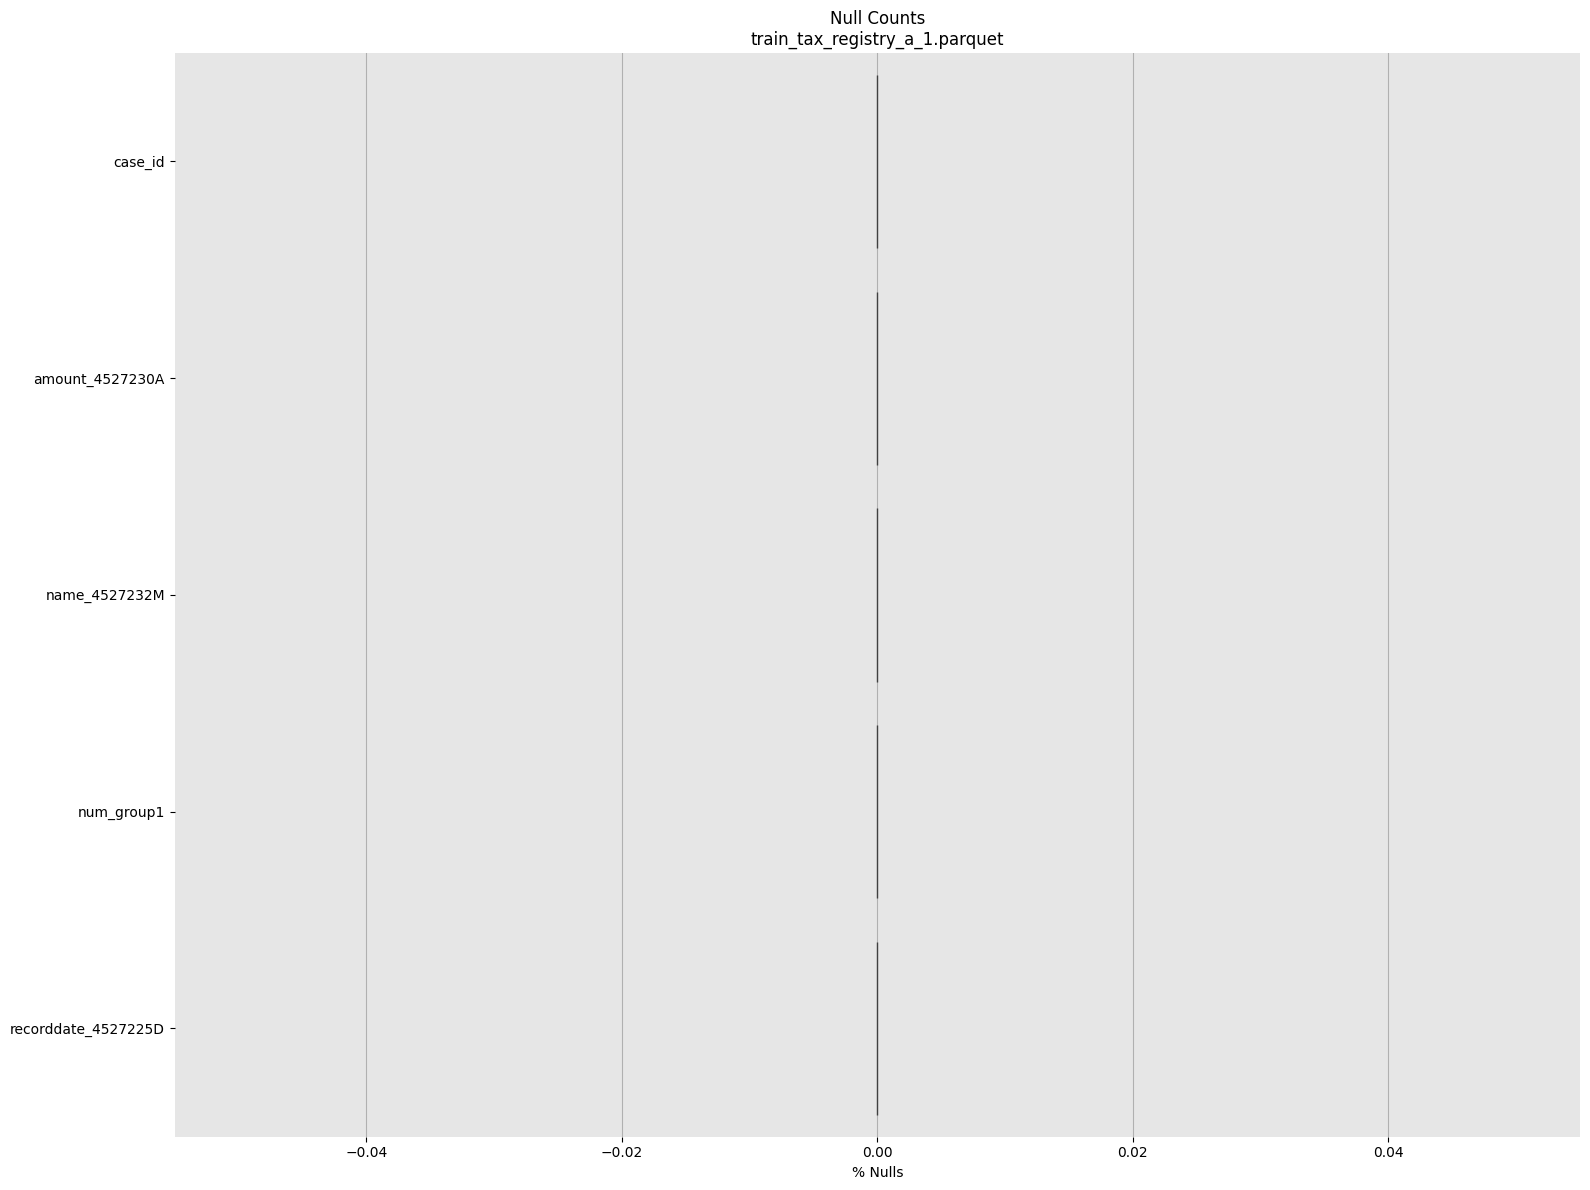

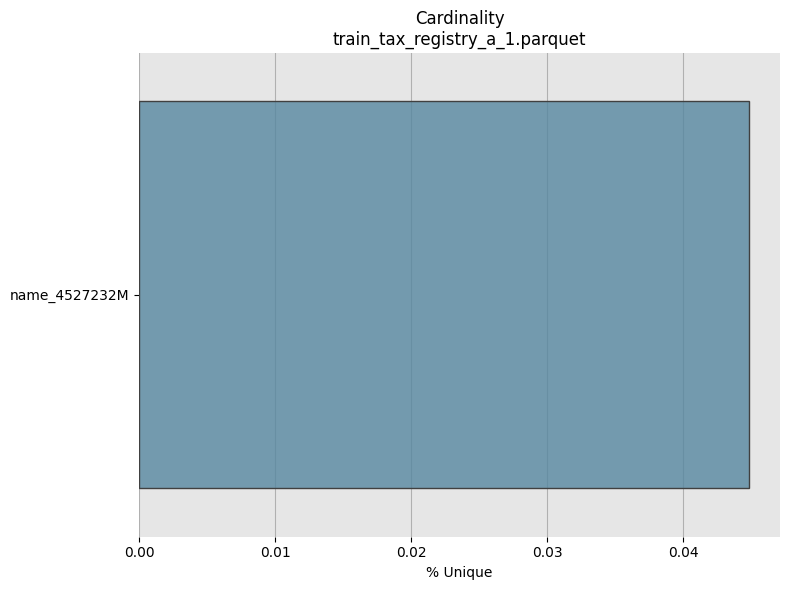

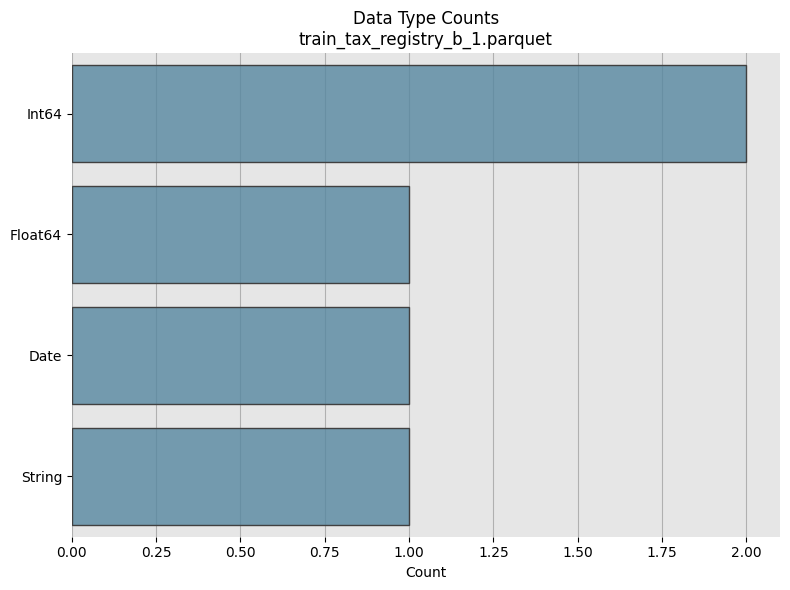

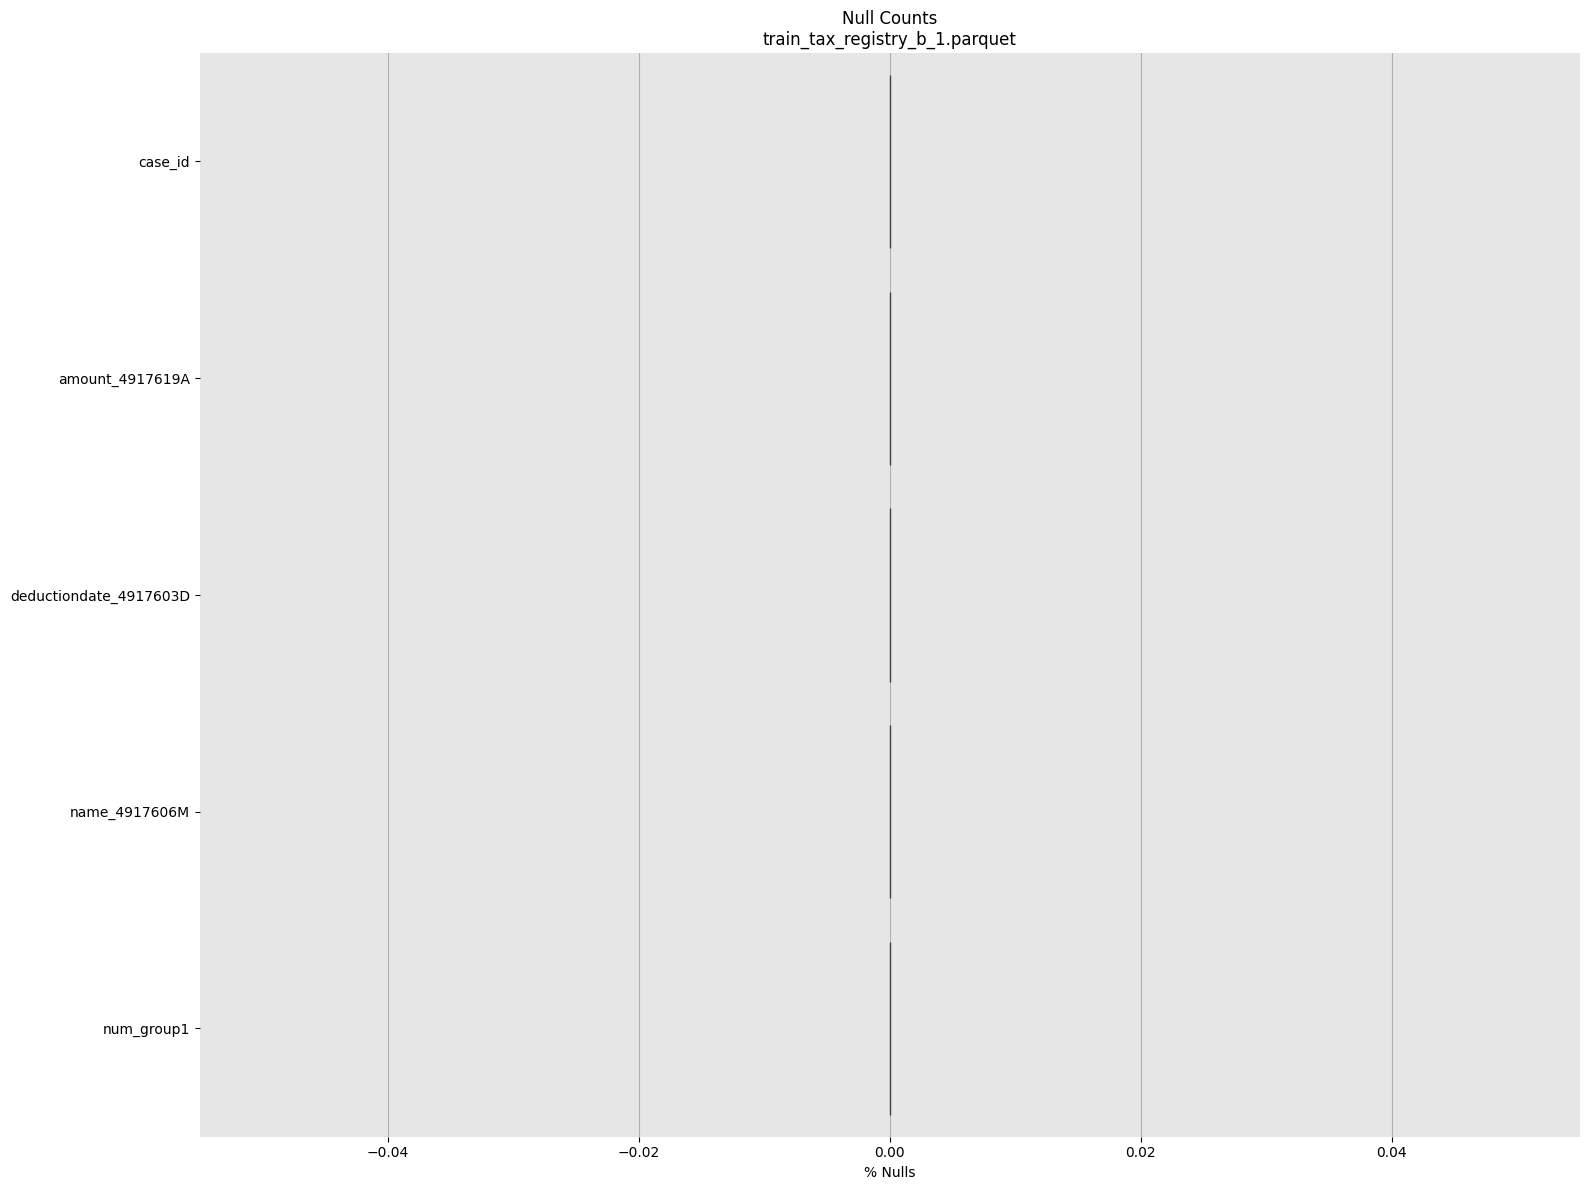

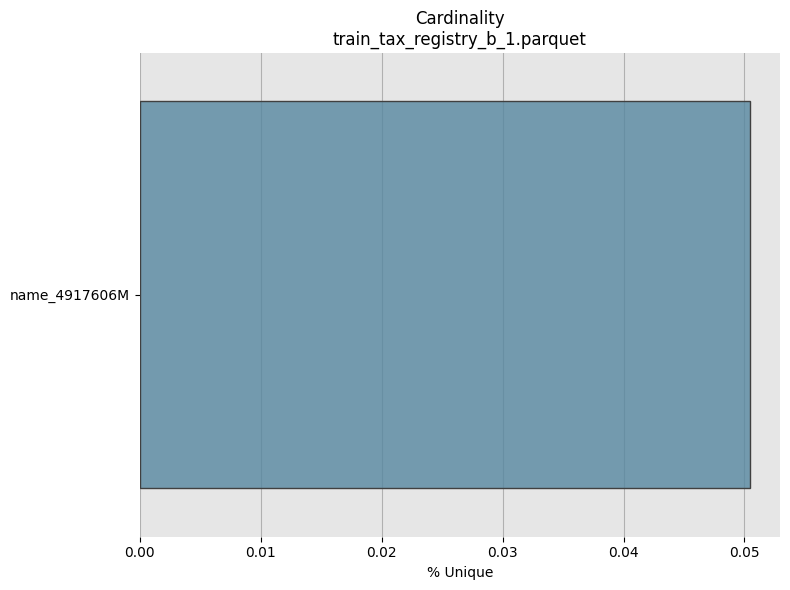

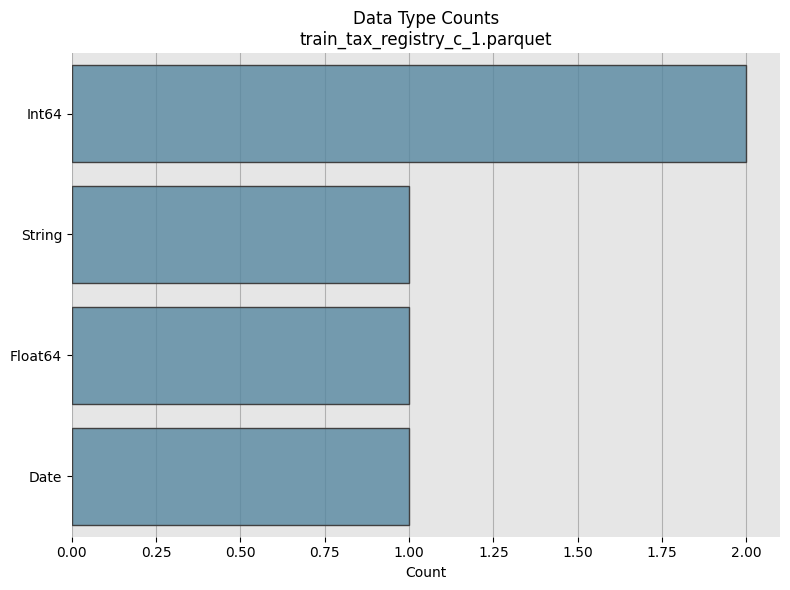

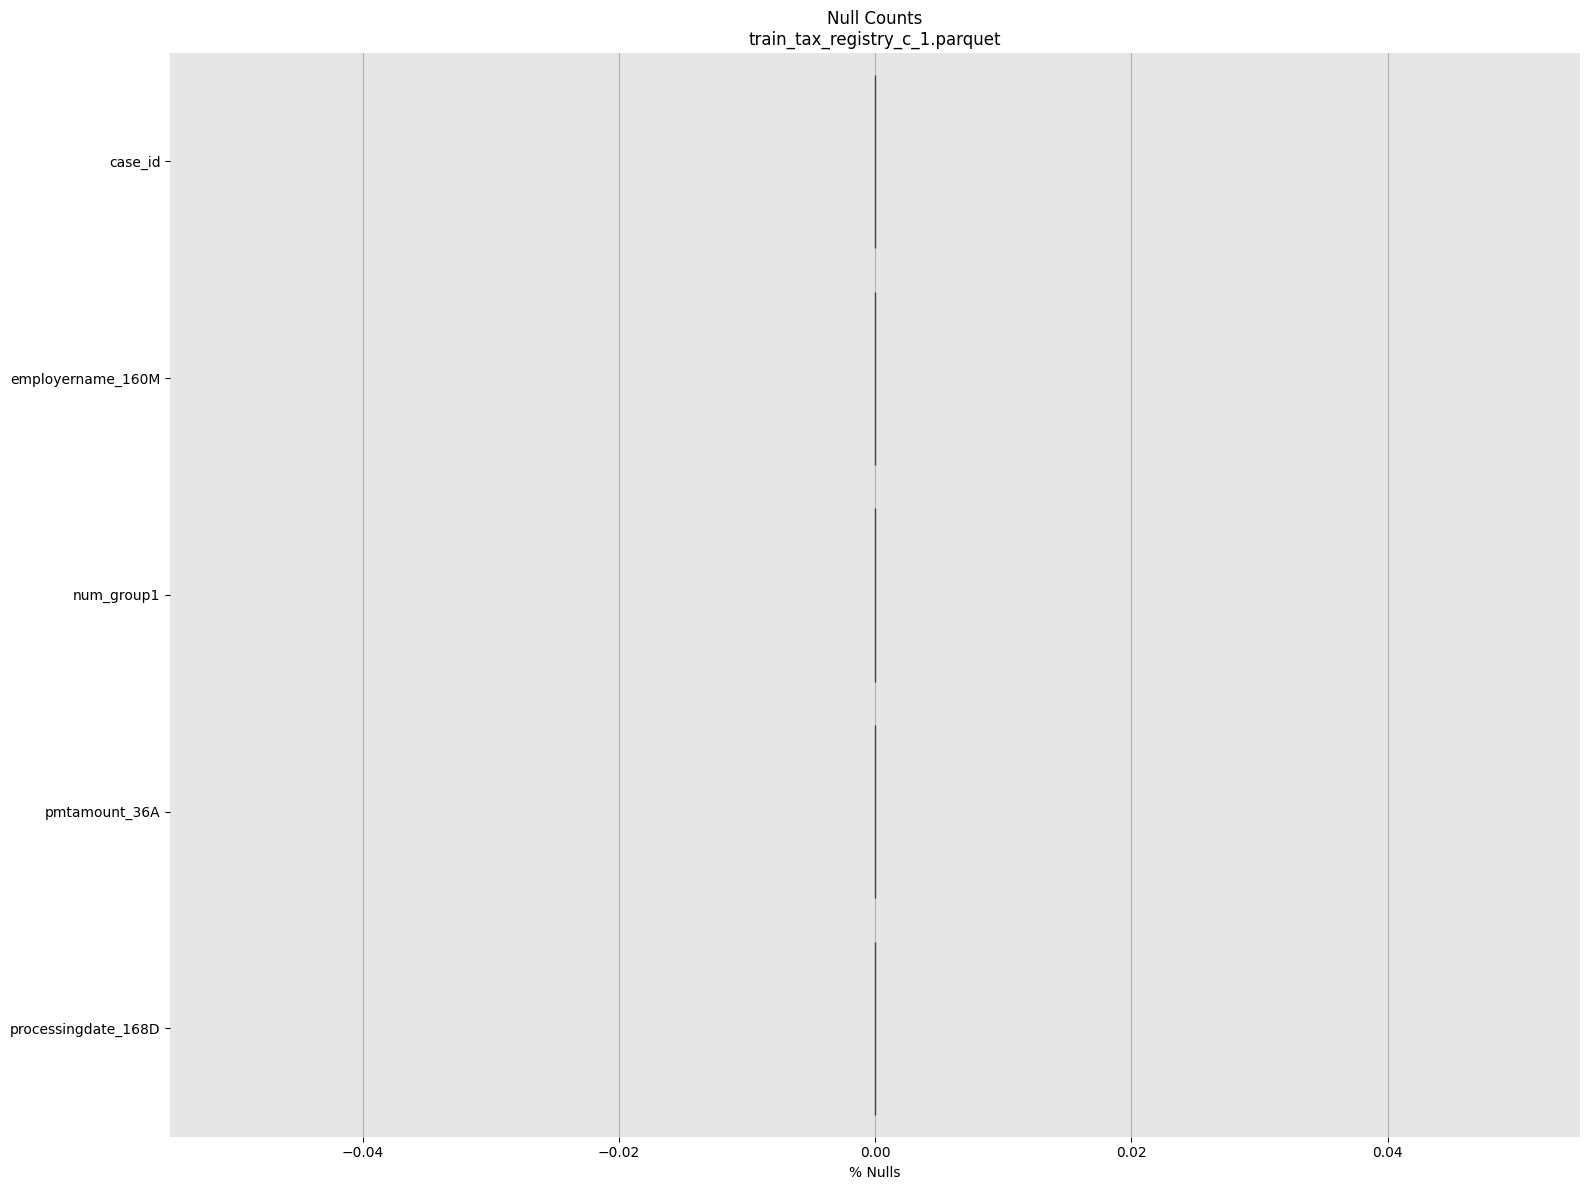

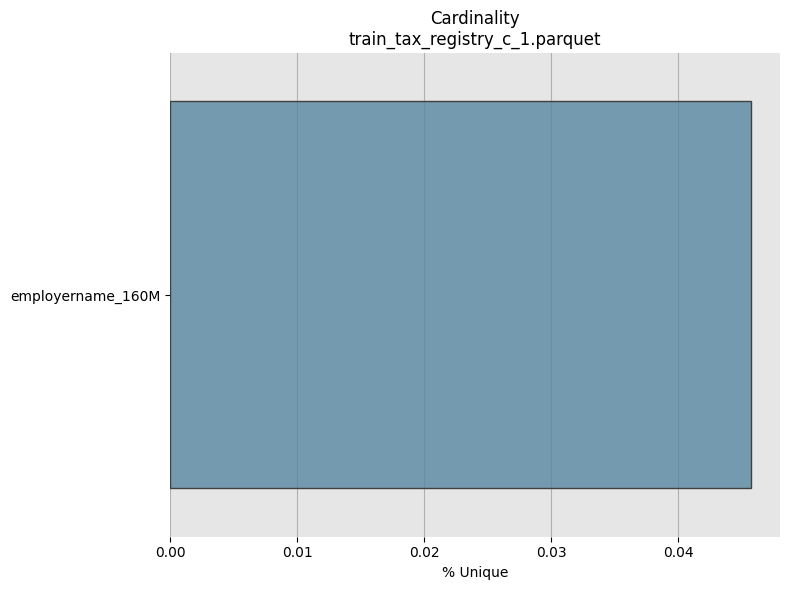

In [8]:
for filename in TRAIN_DIR.glob("*tax_registry_*parquet"):
    df = pl.read_parquet(filename).pipe(Pipeline.set_table_dtypes)
    plot_dtype_count(df, filename)
    plot_nulls(df, filename)
    plot_cardinality(df, filename)
    del df
    gc.collect()

## Credit Bureau Files

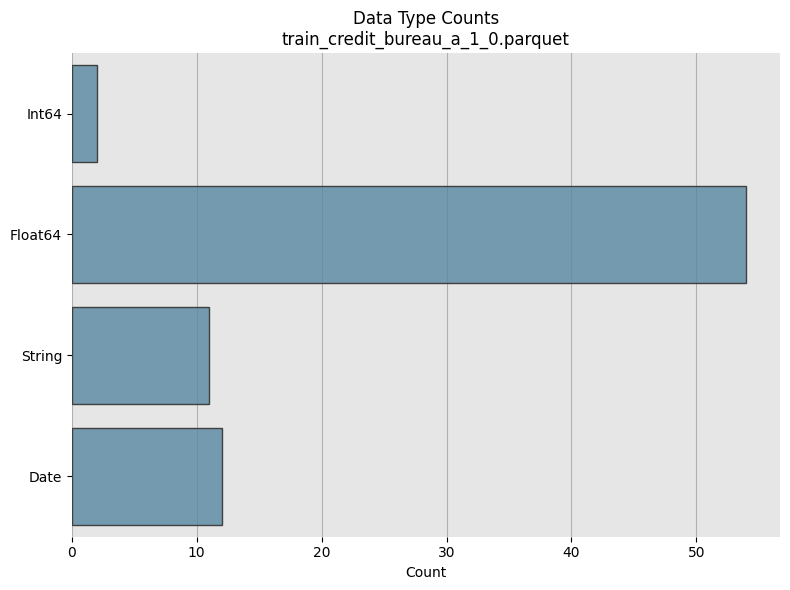

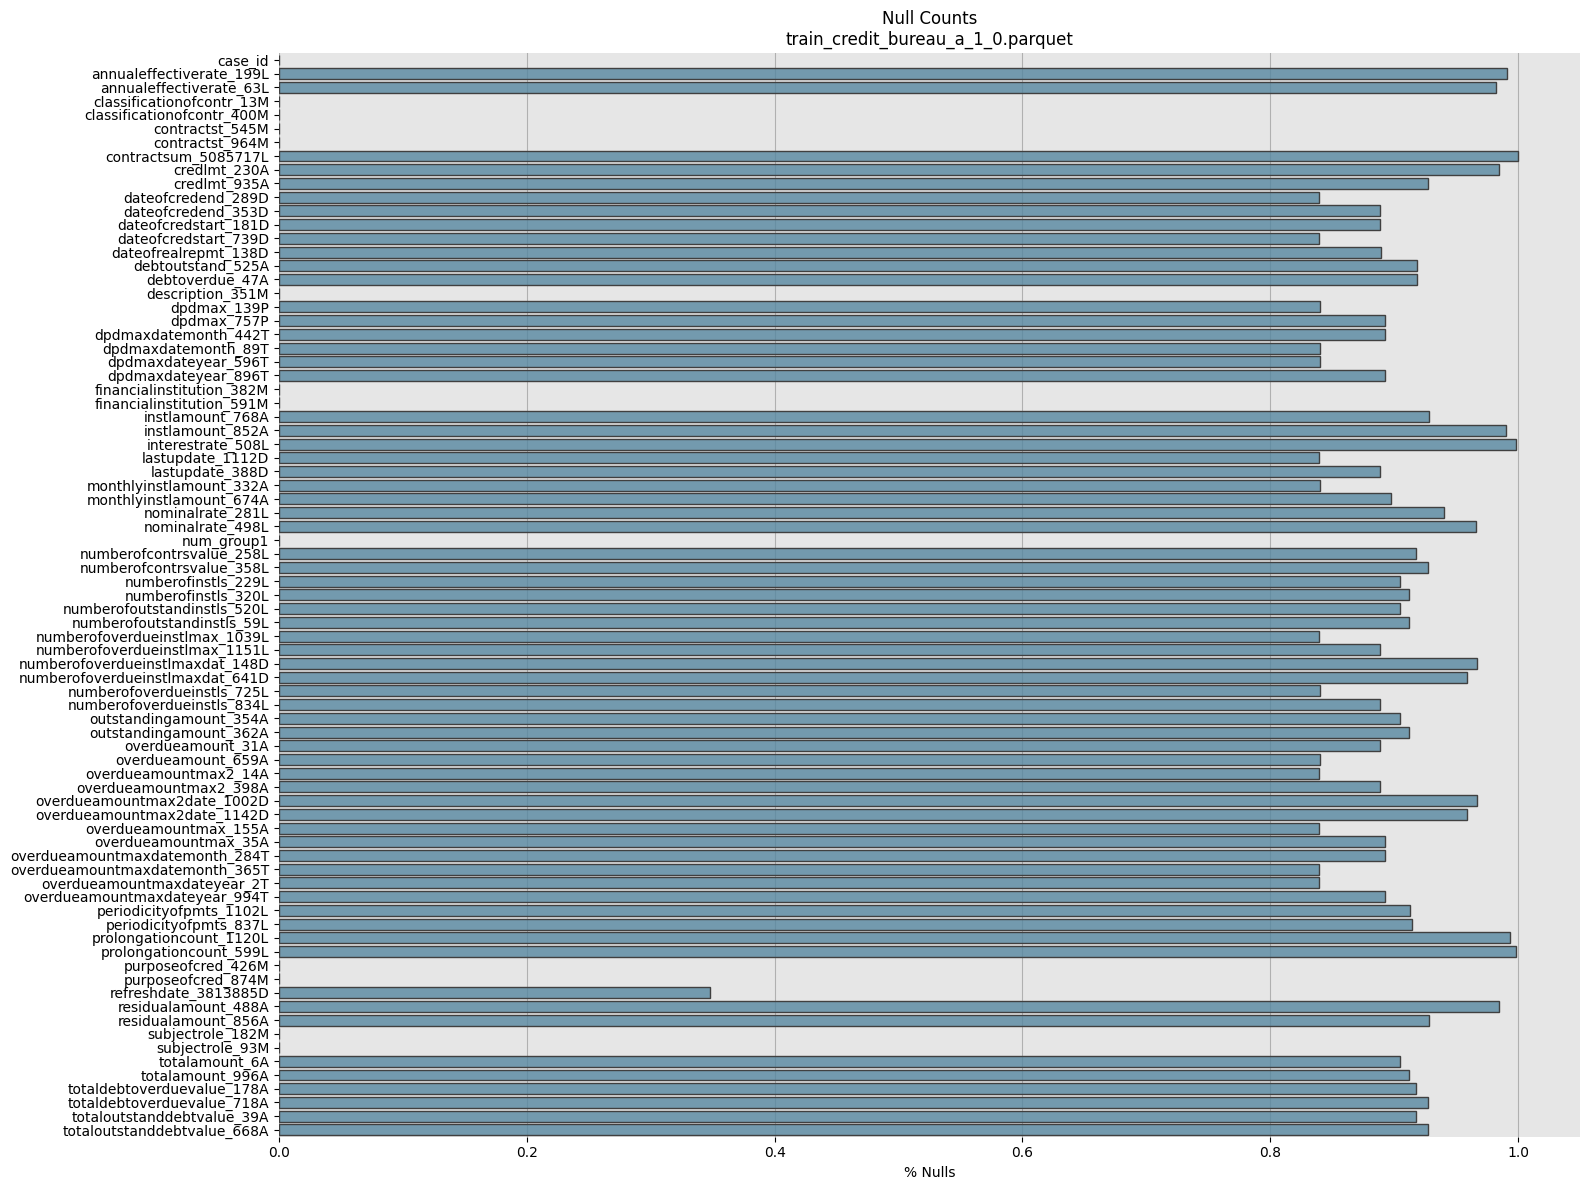

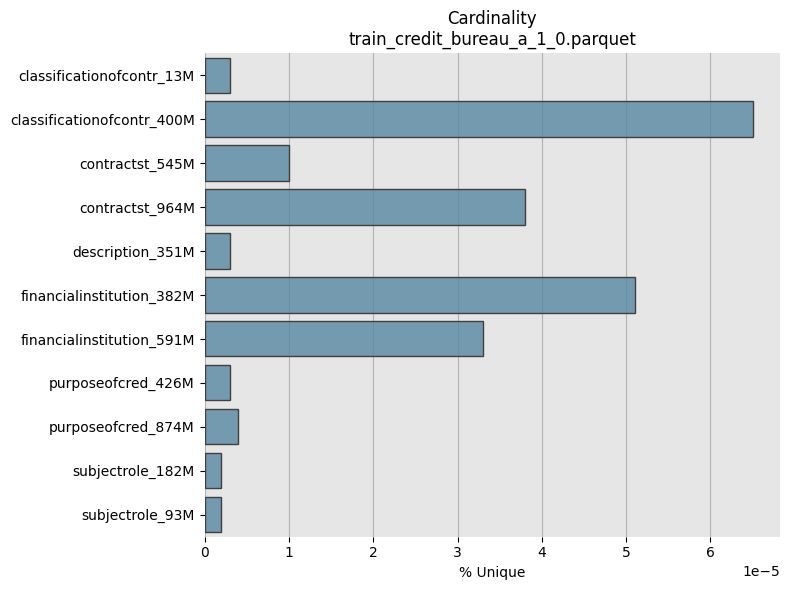

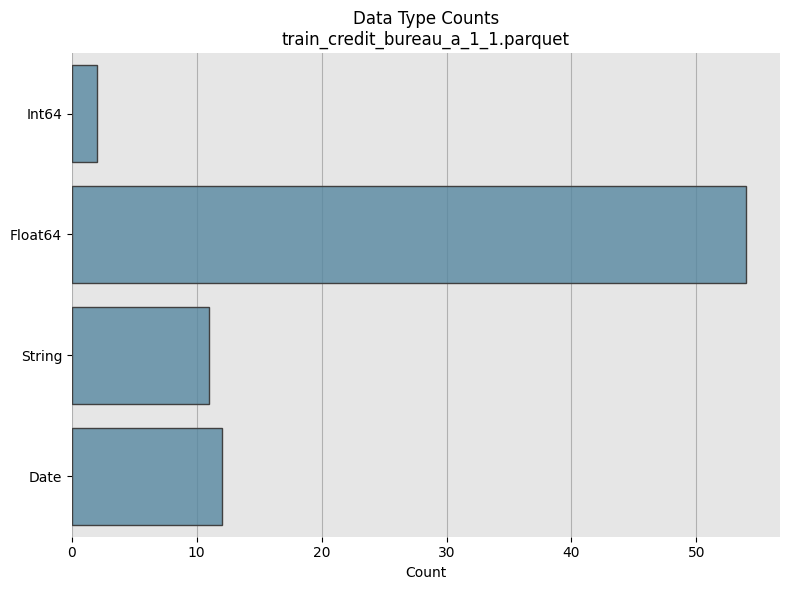

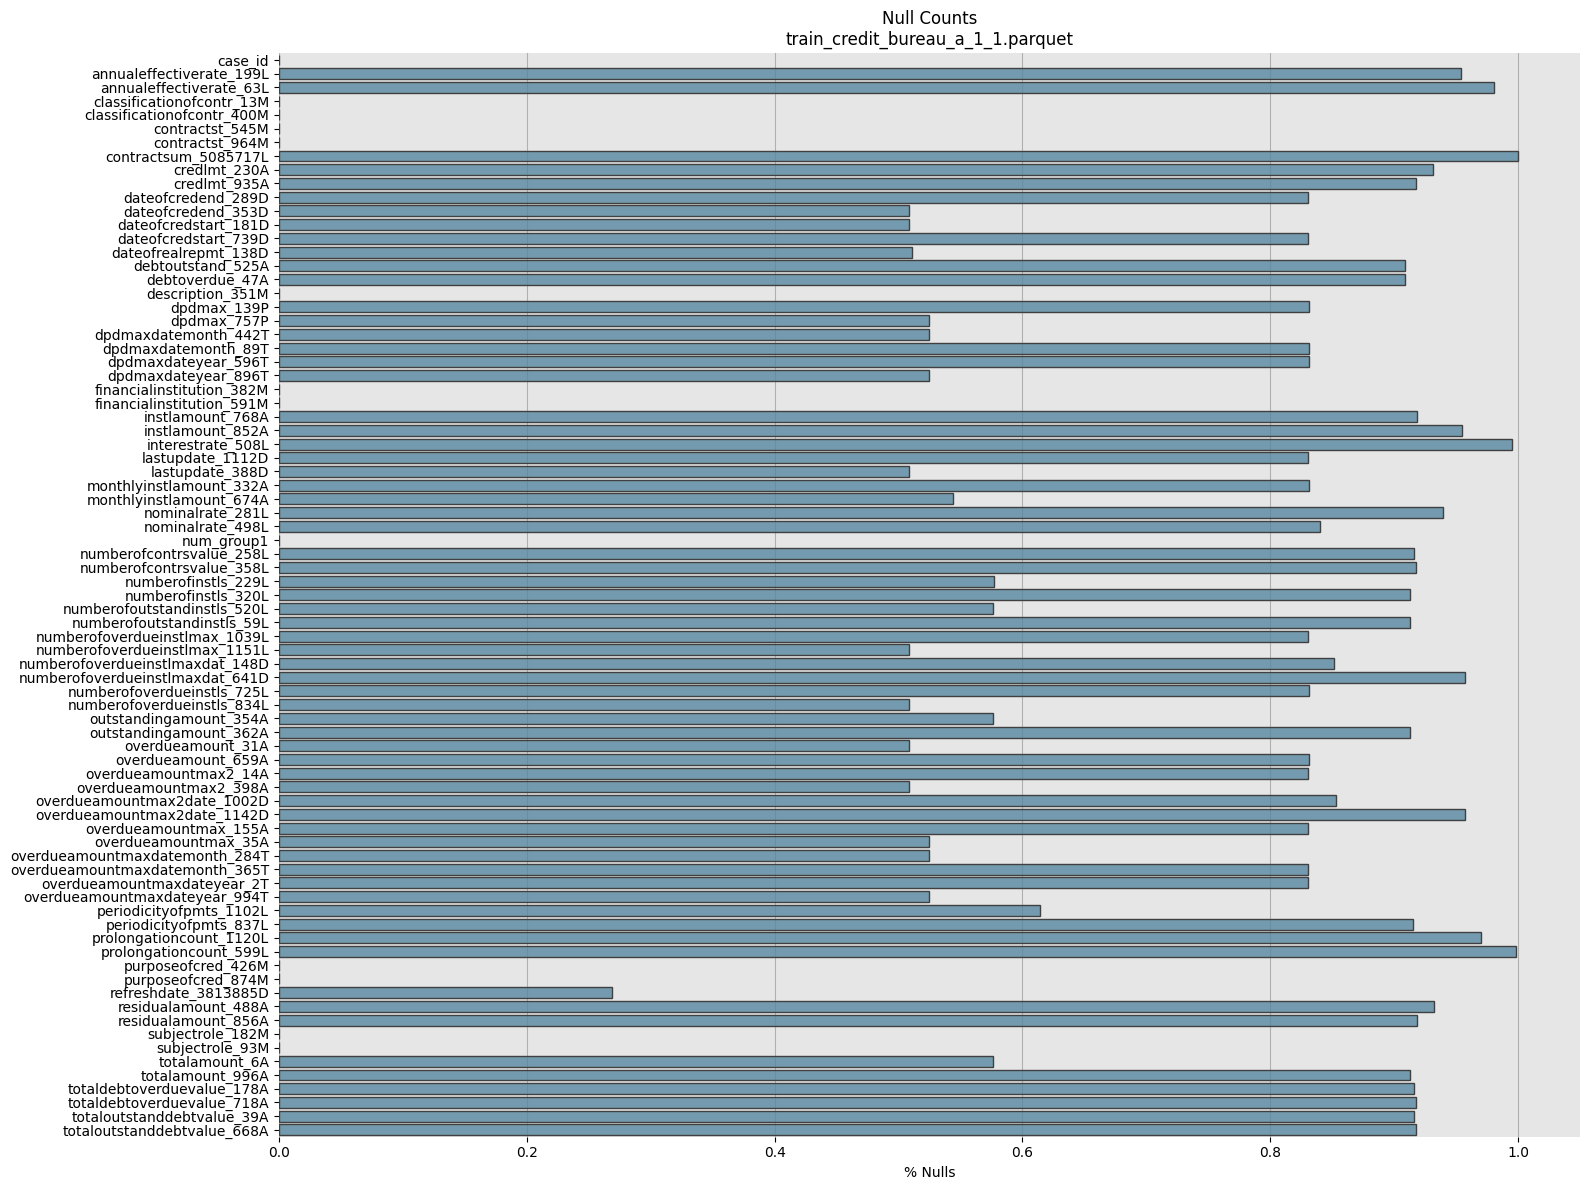

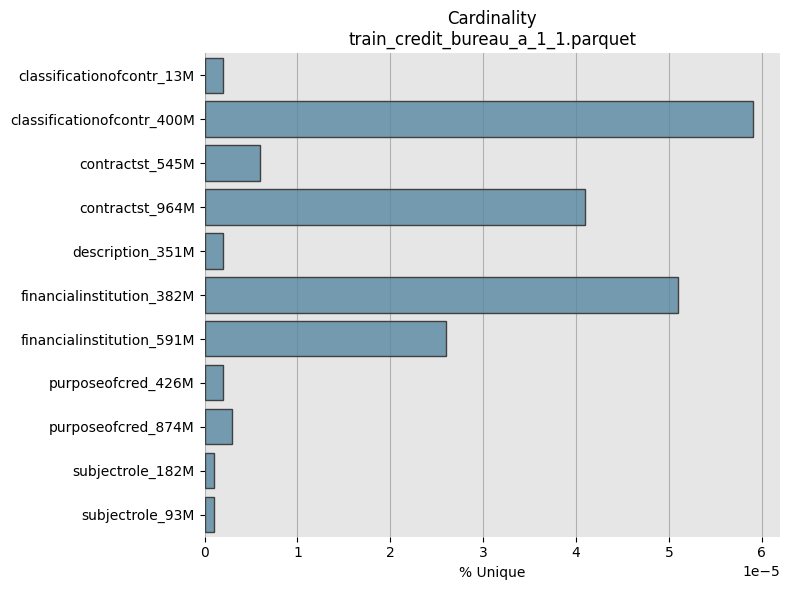

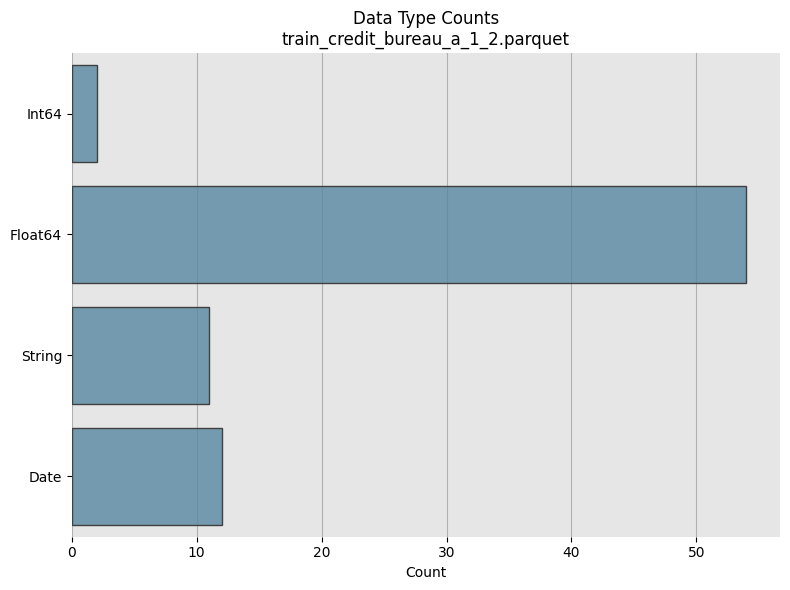

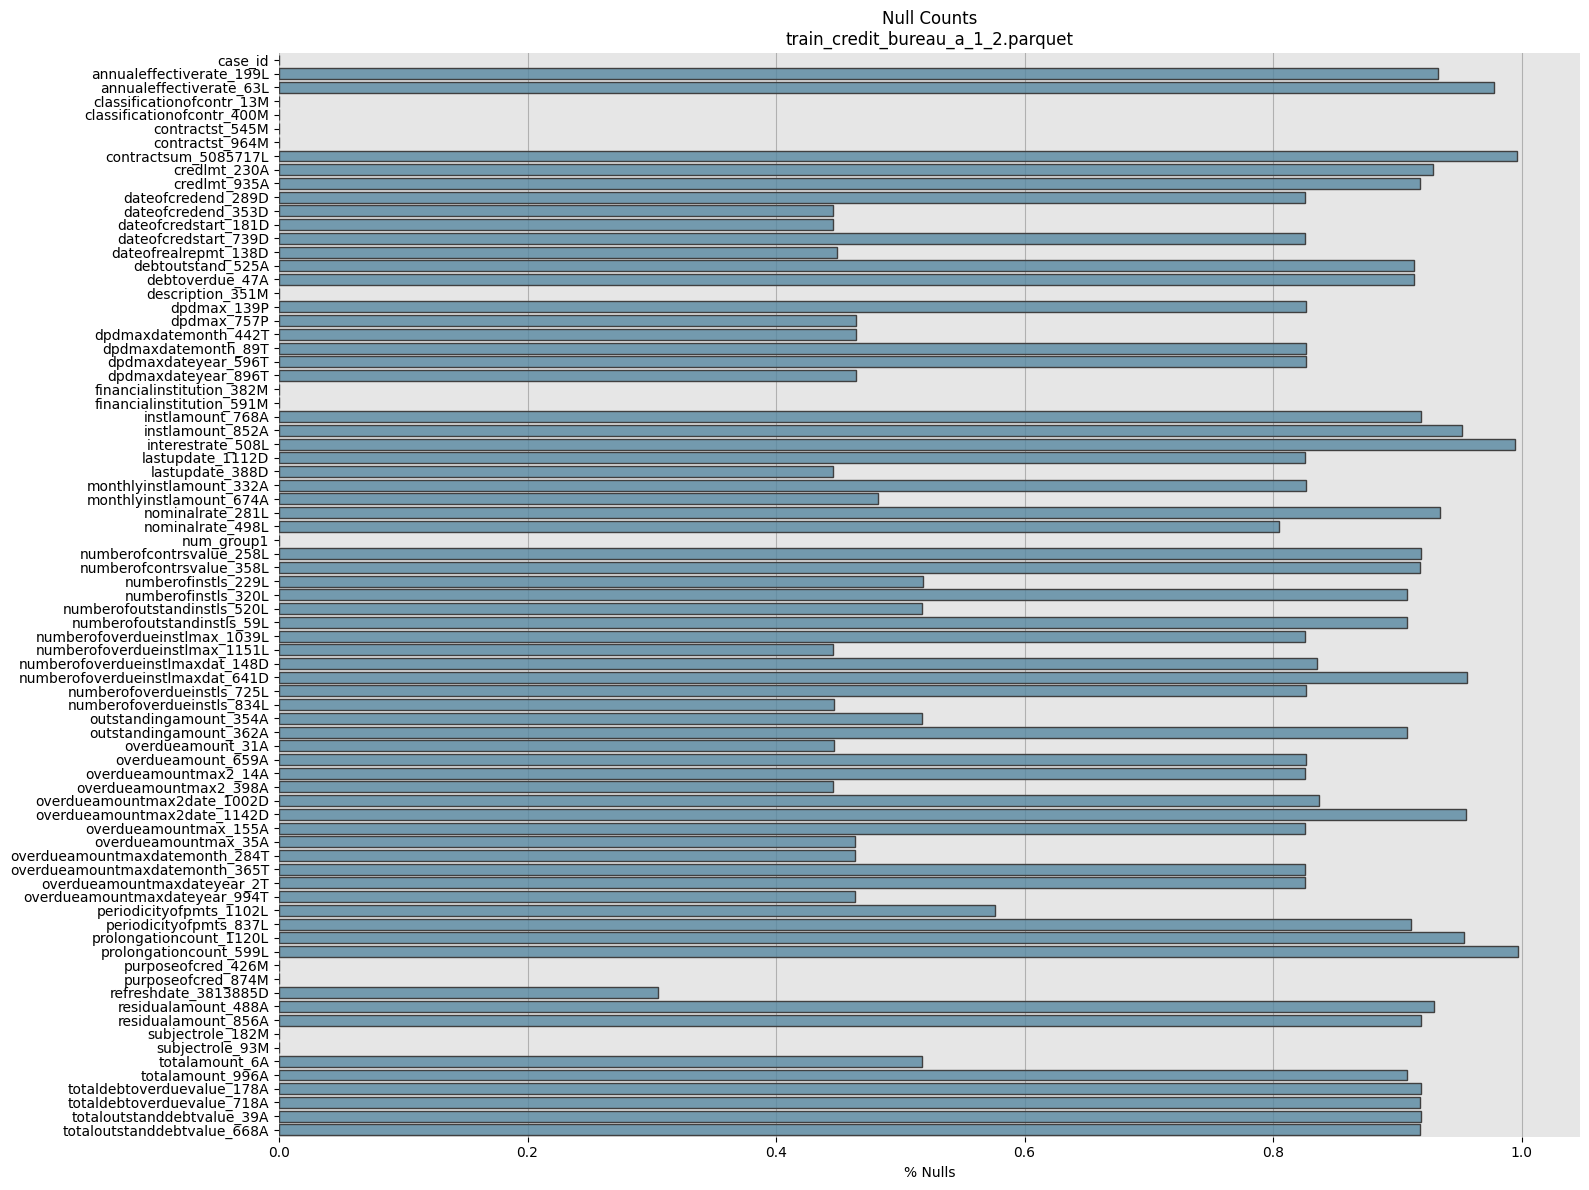

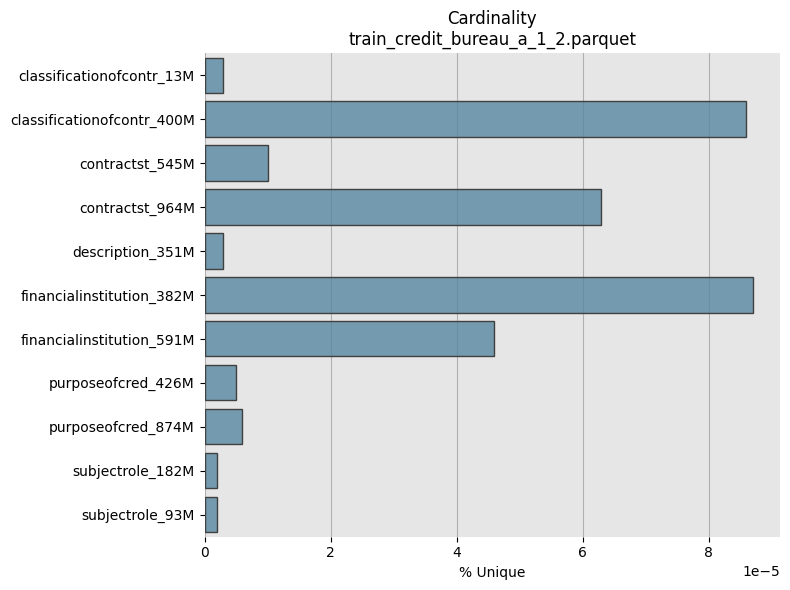

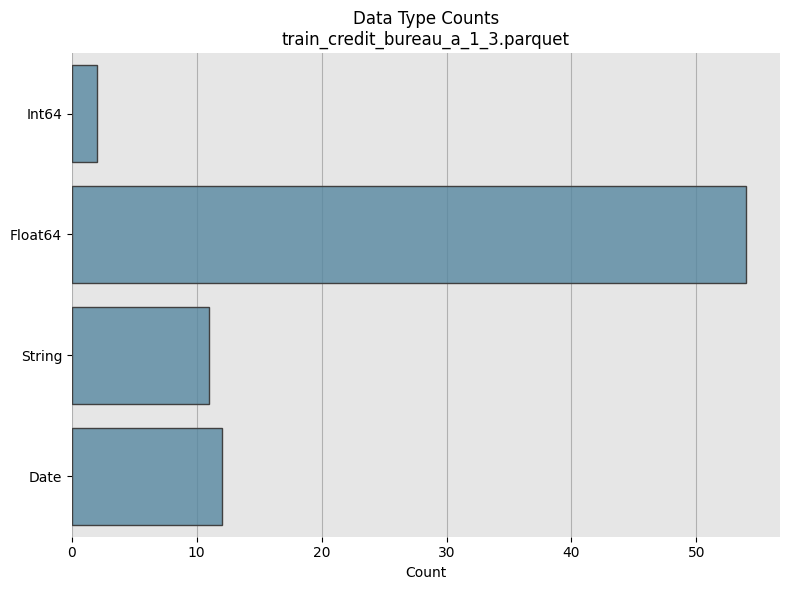

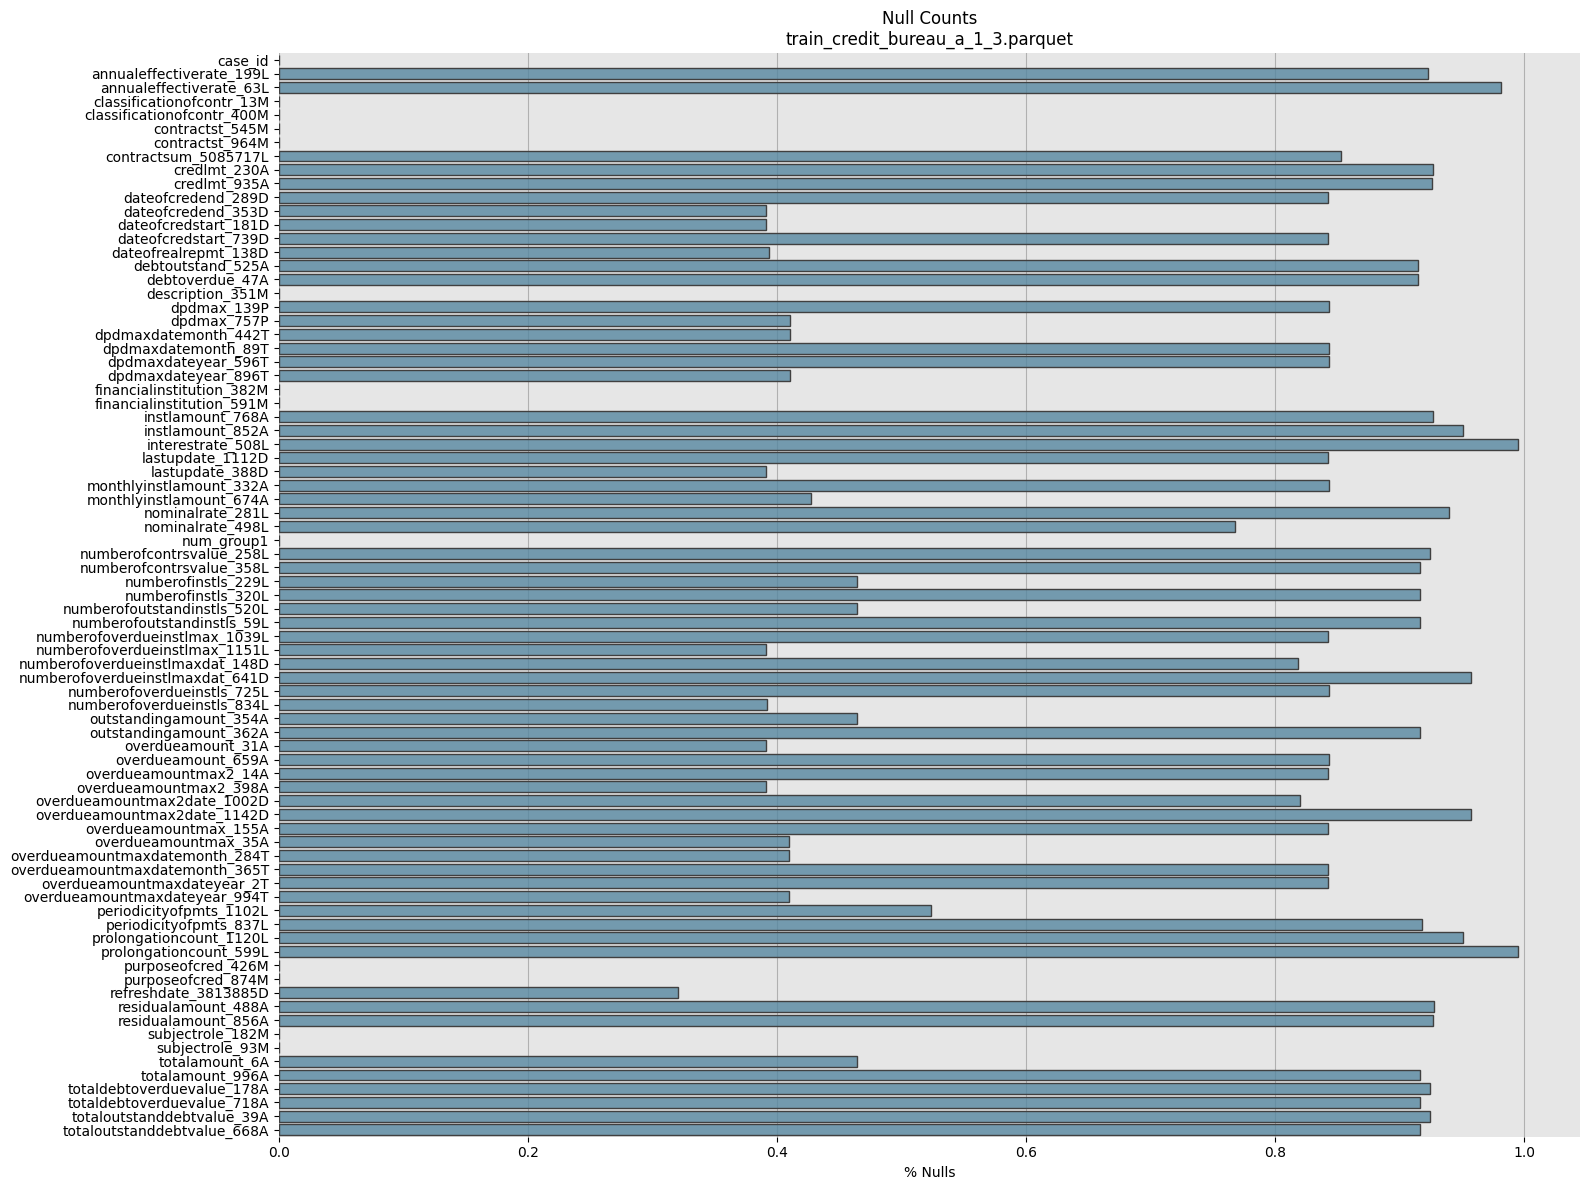

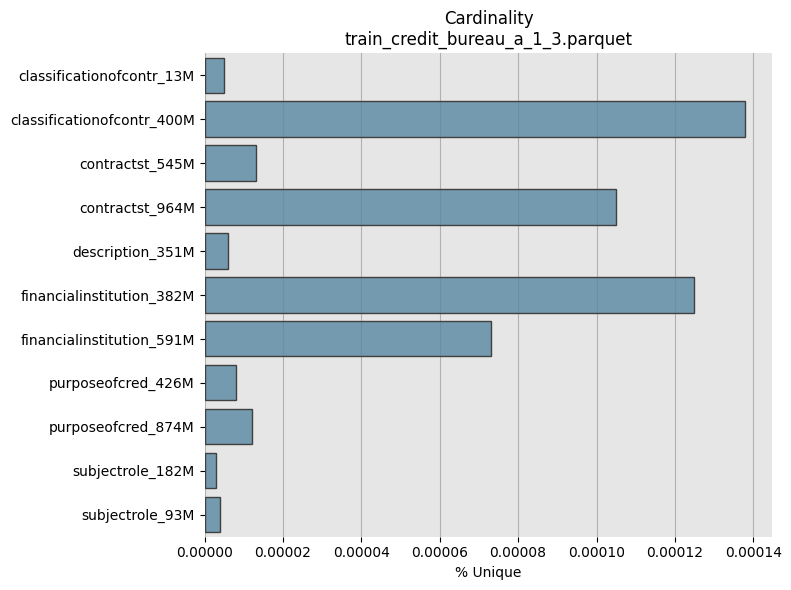

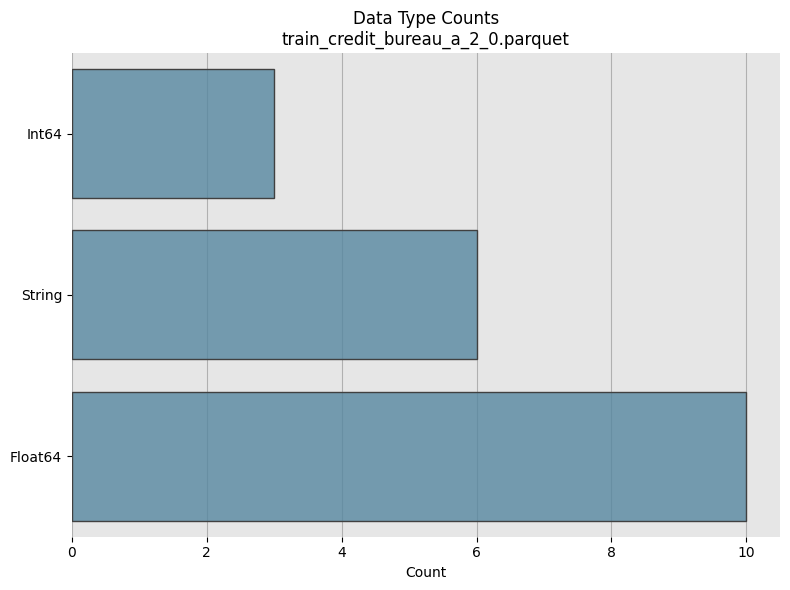

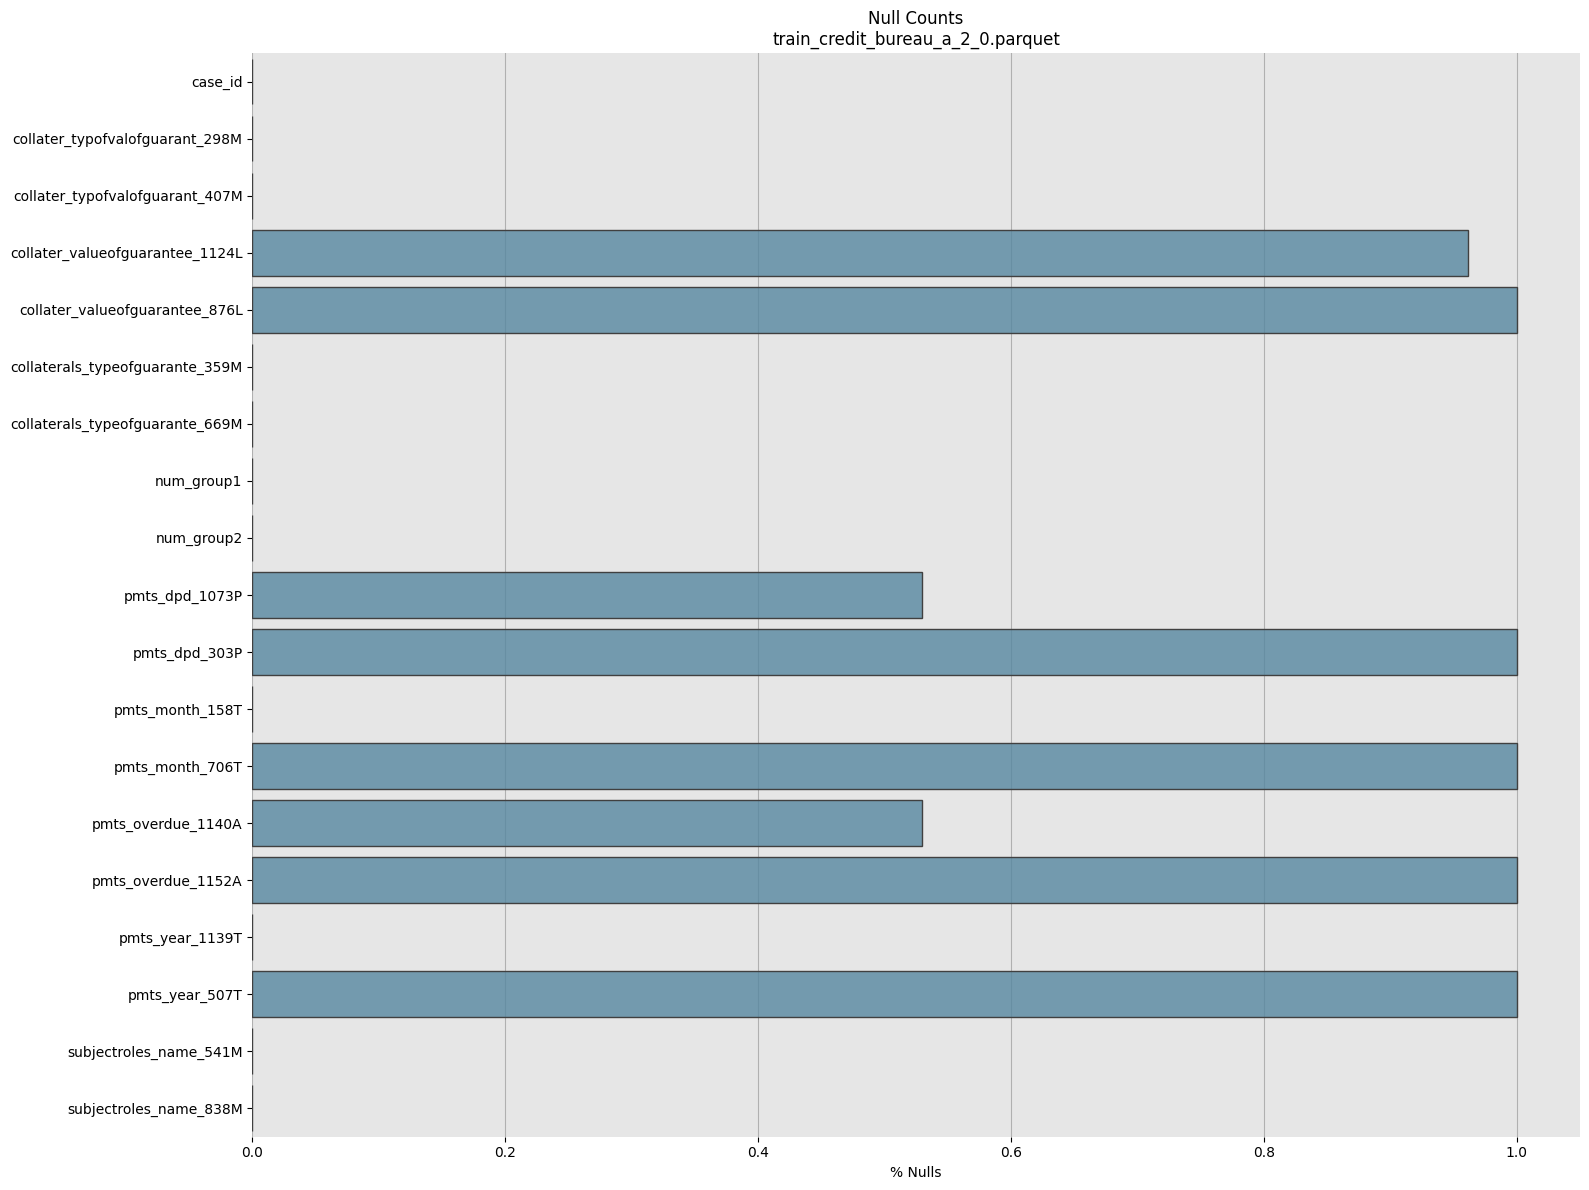

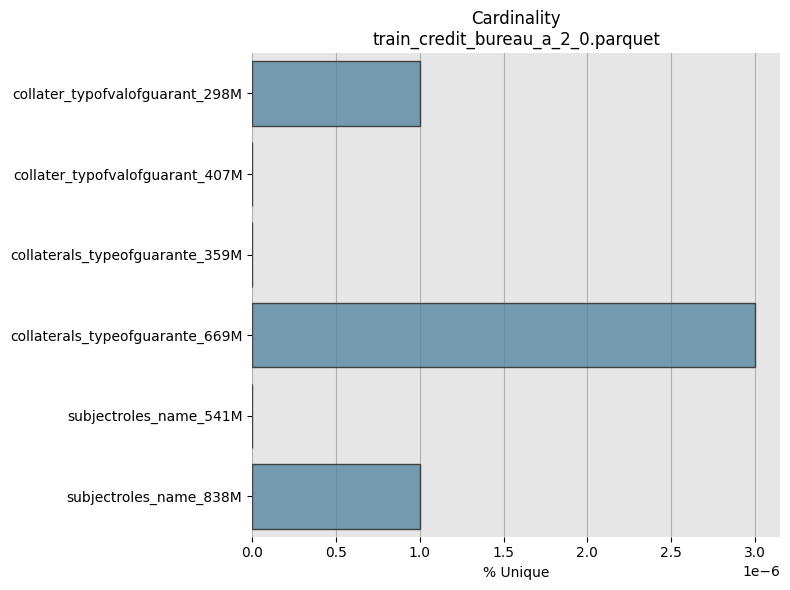

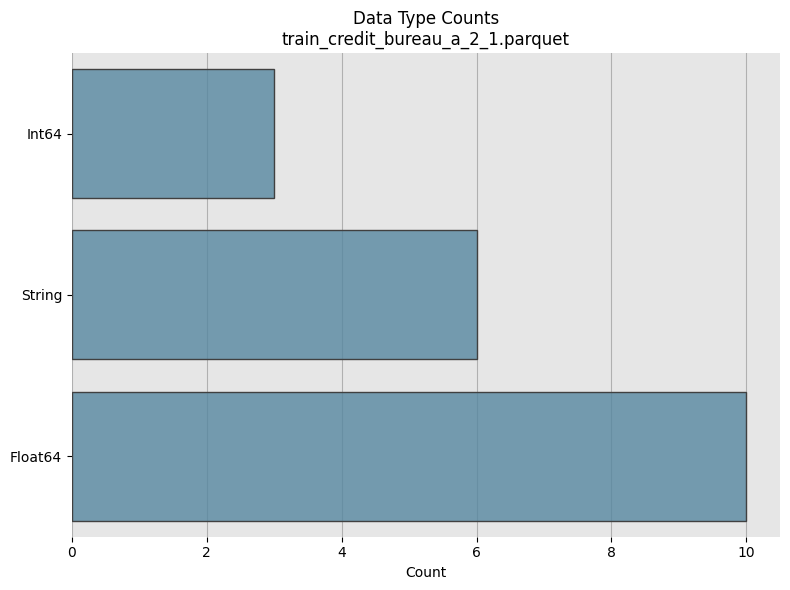

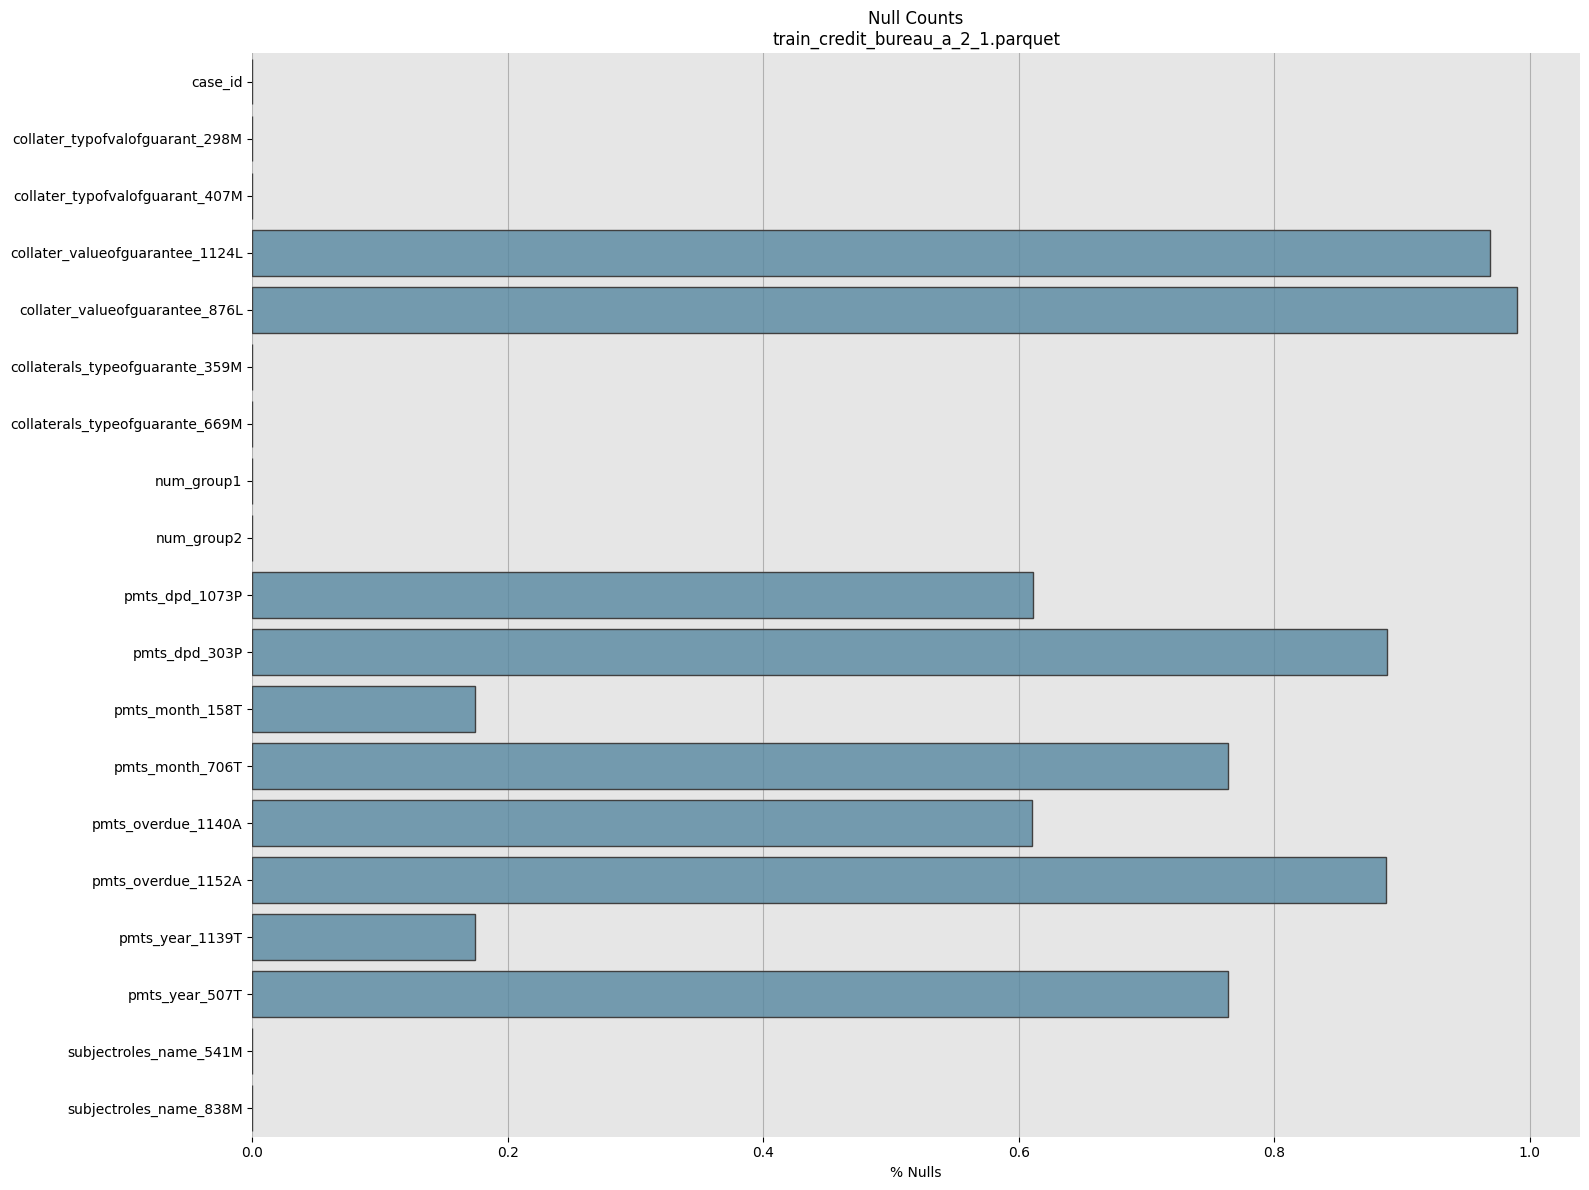

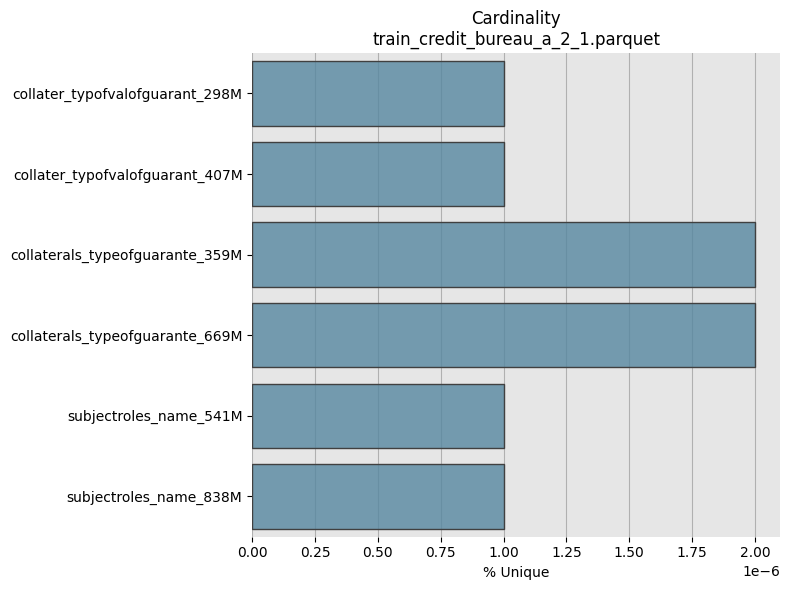

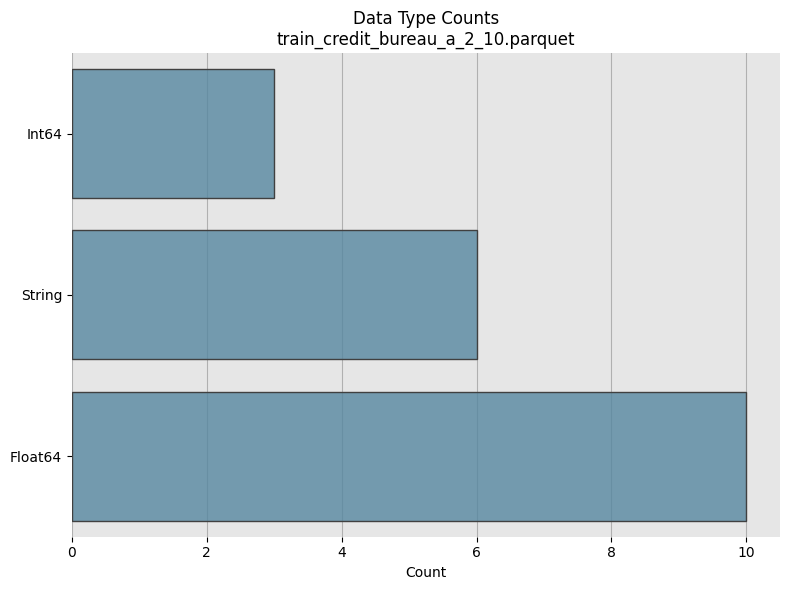

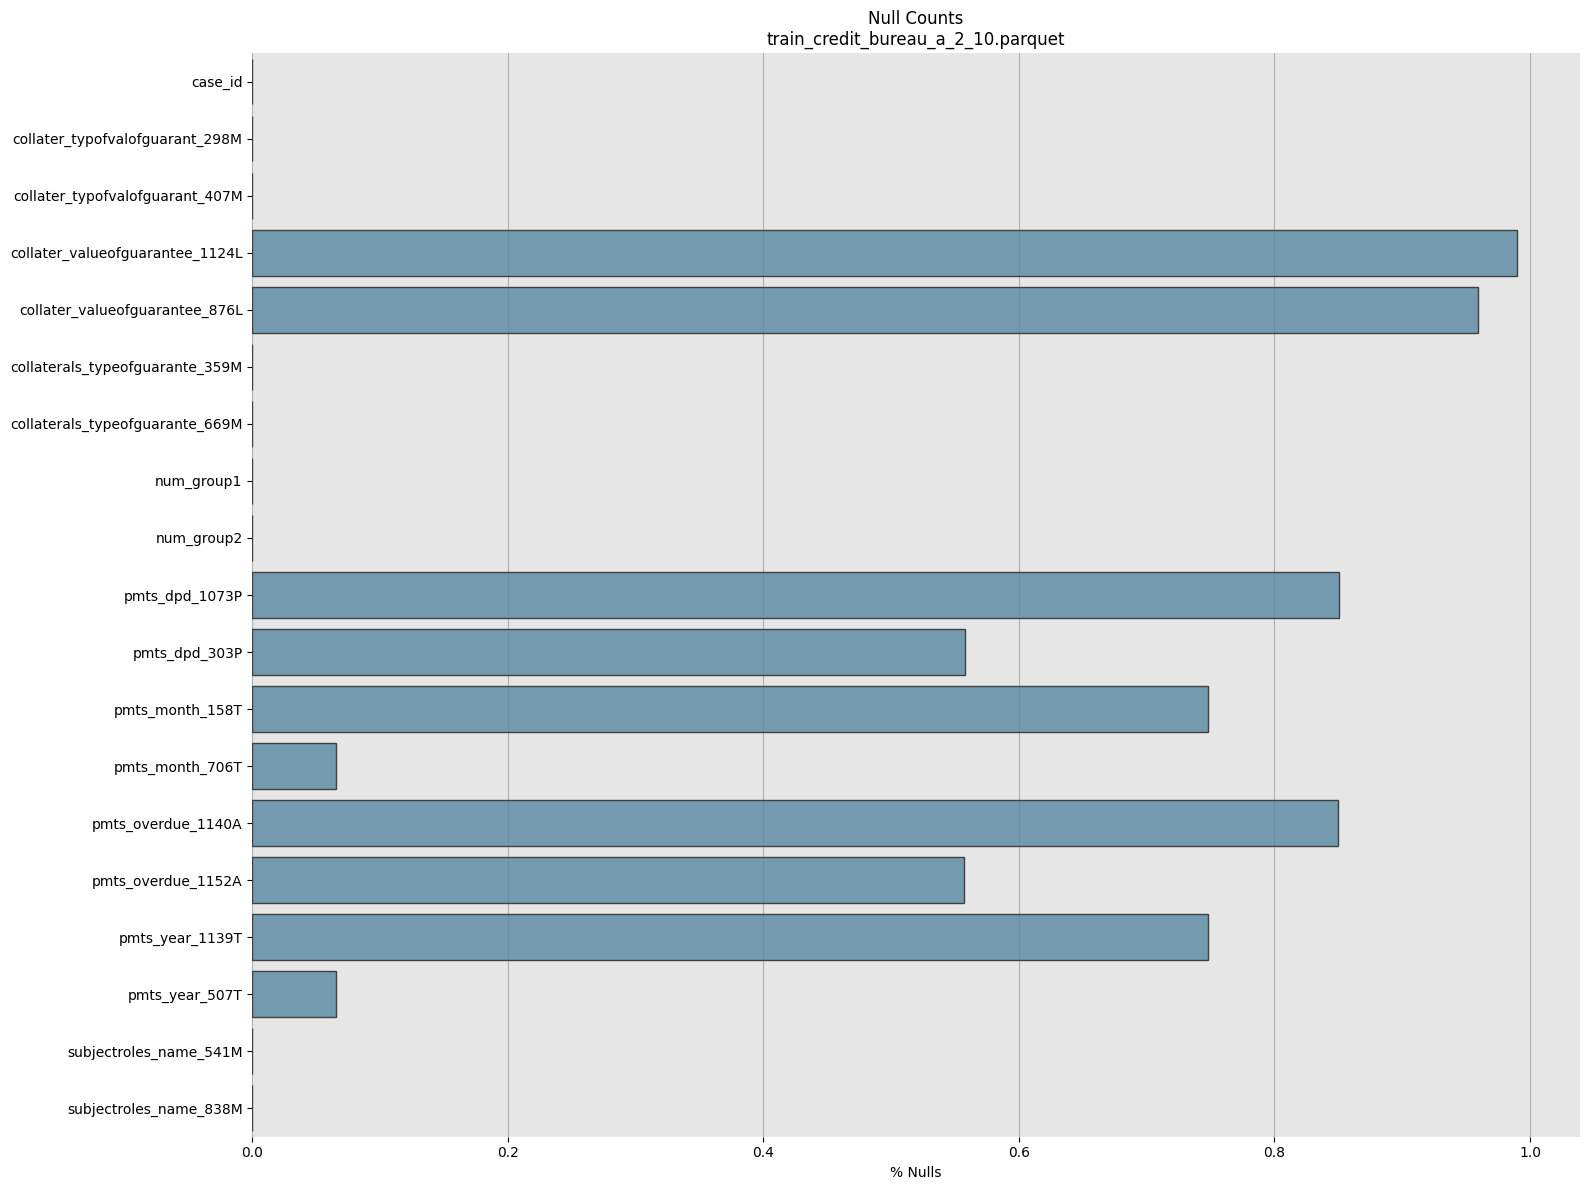

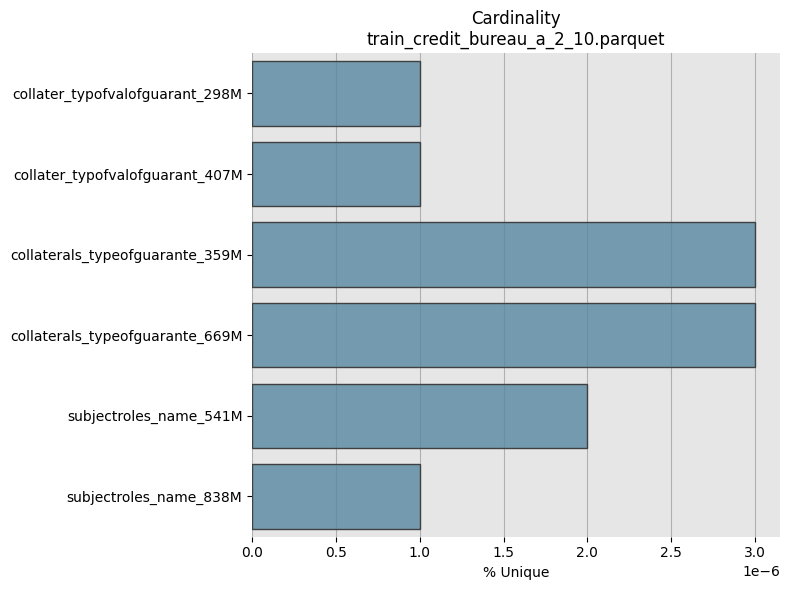

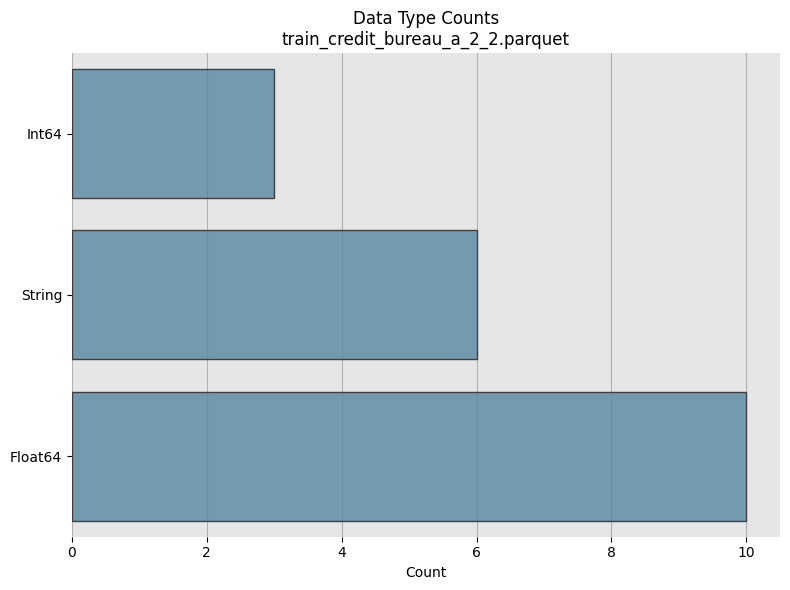

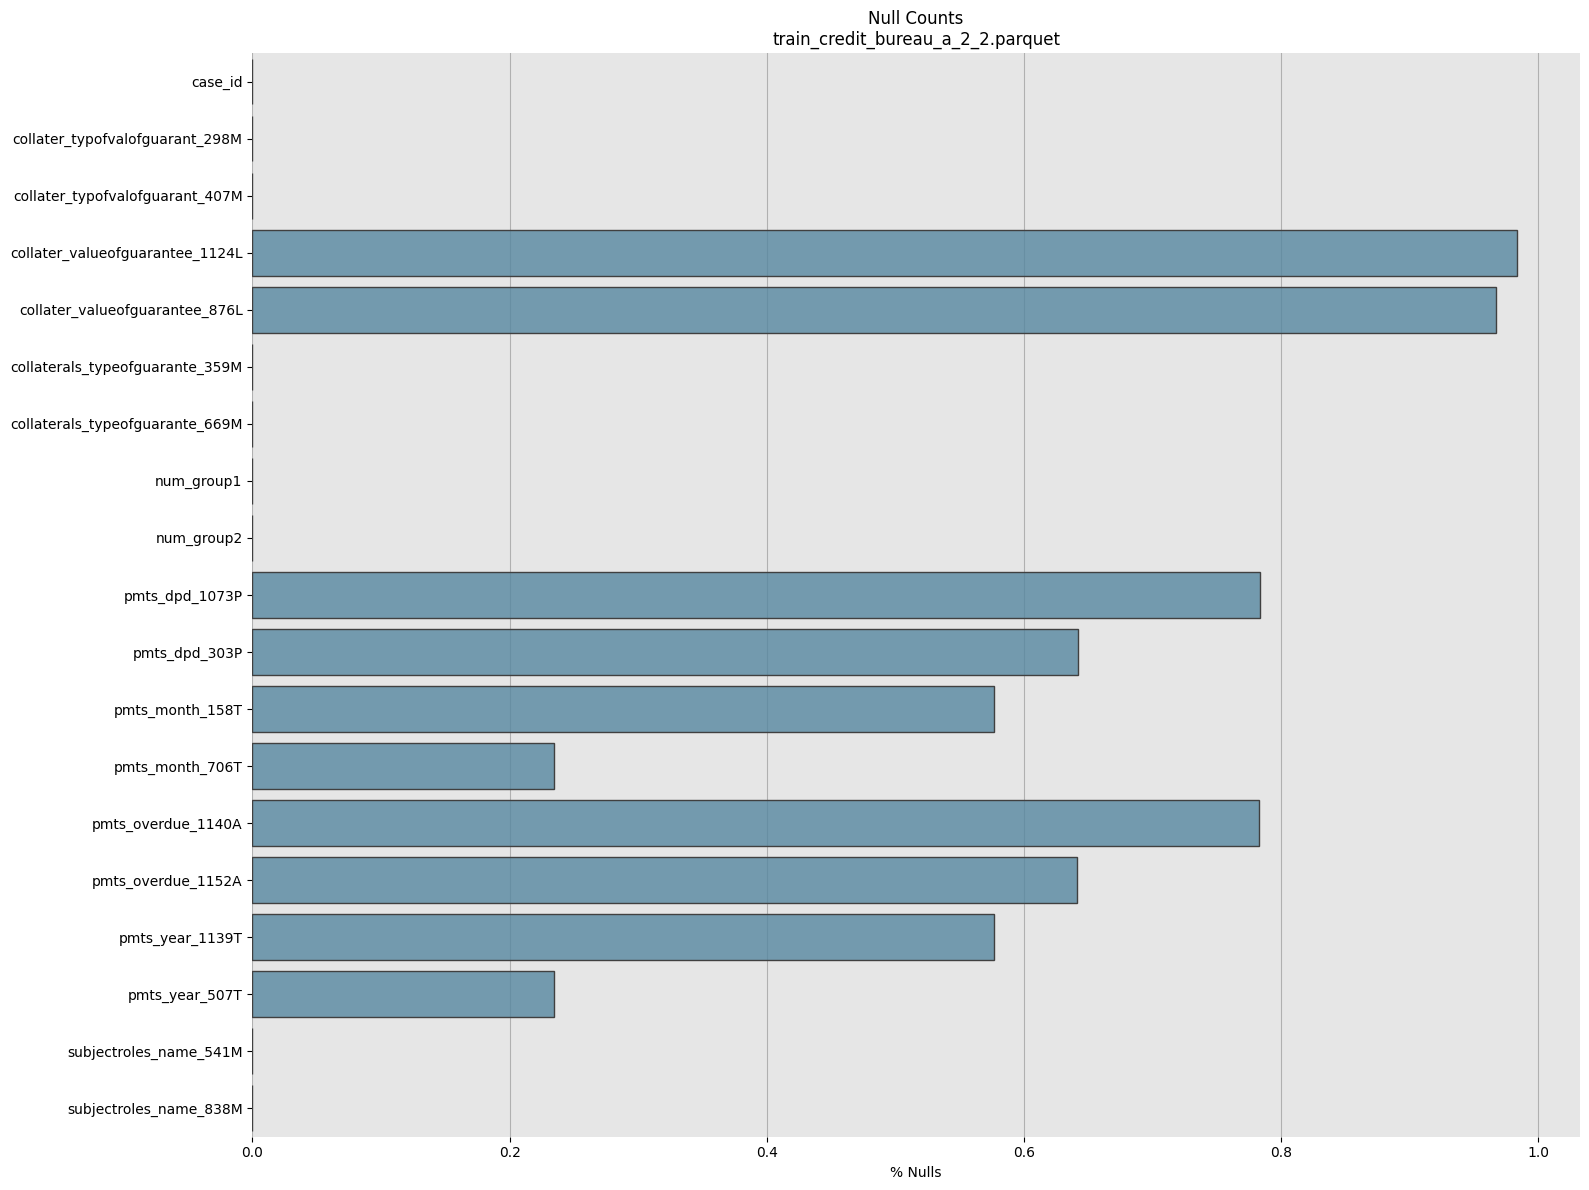

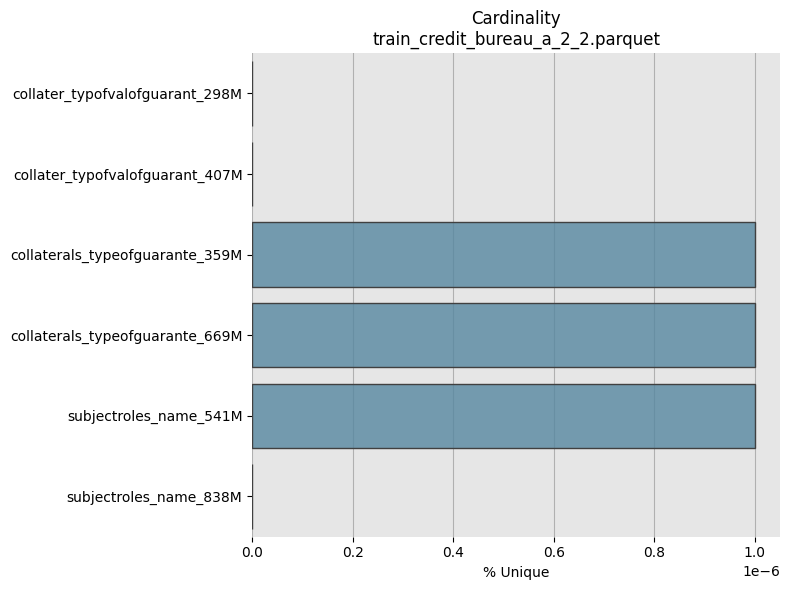

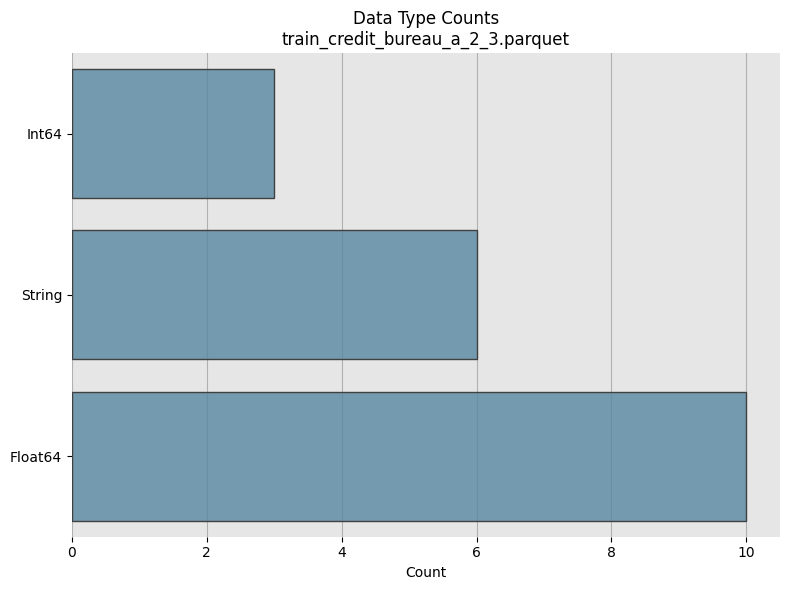

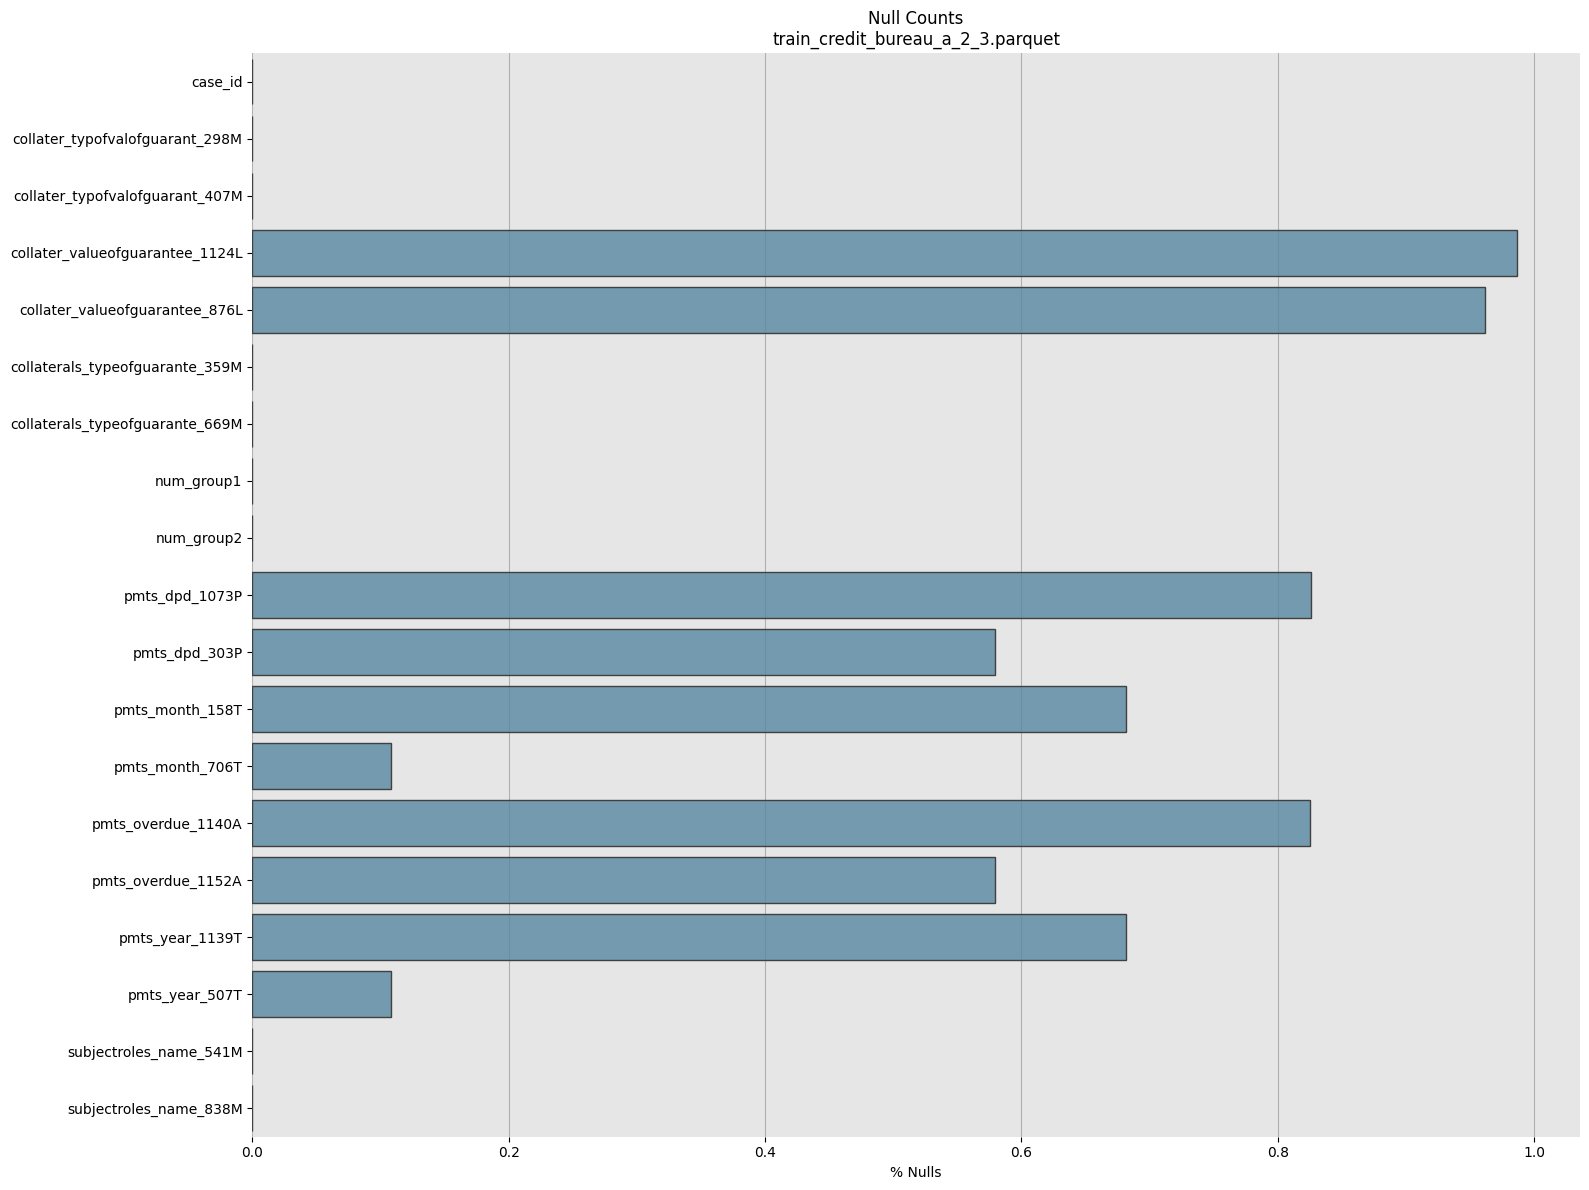

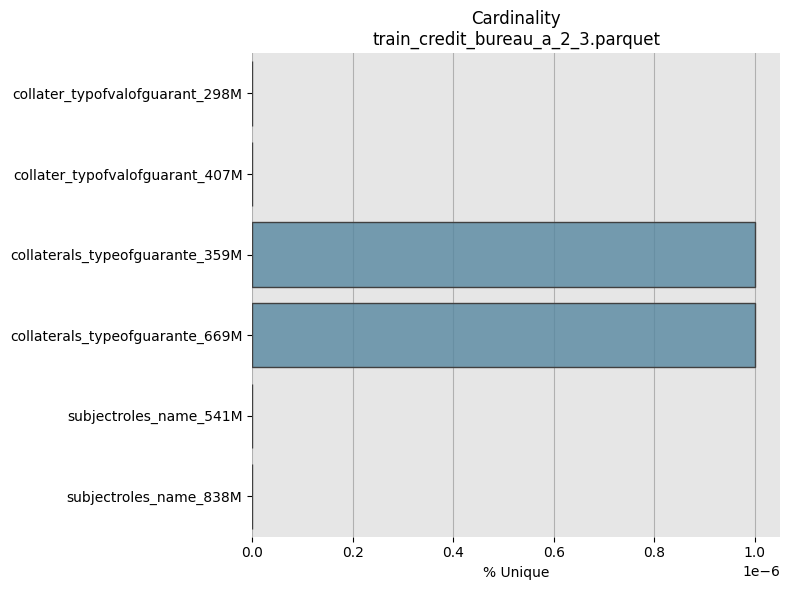

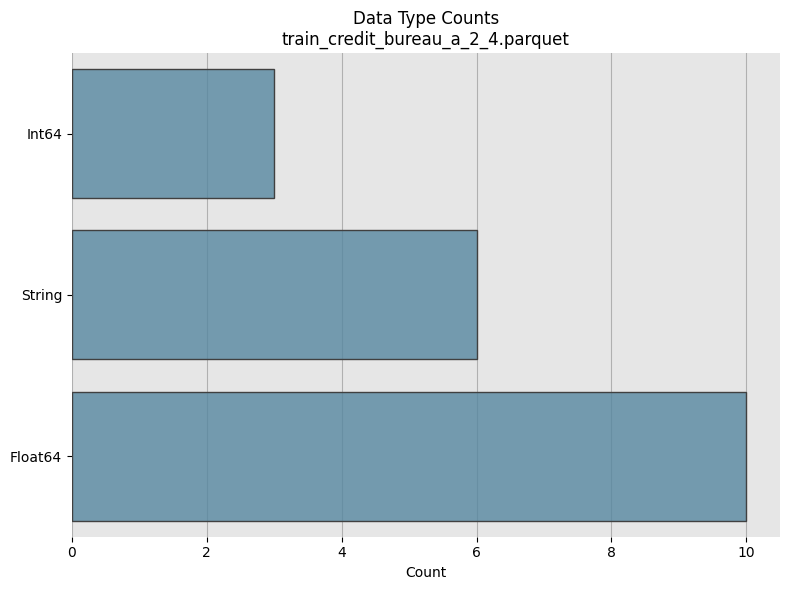

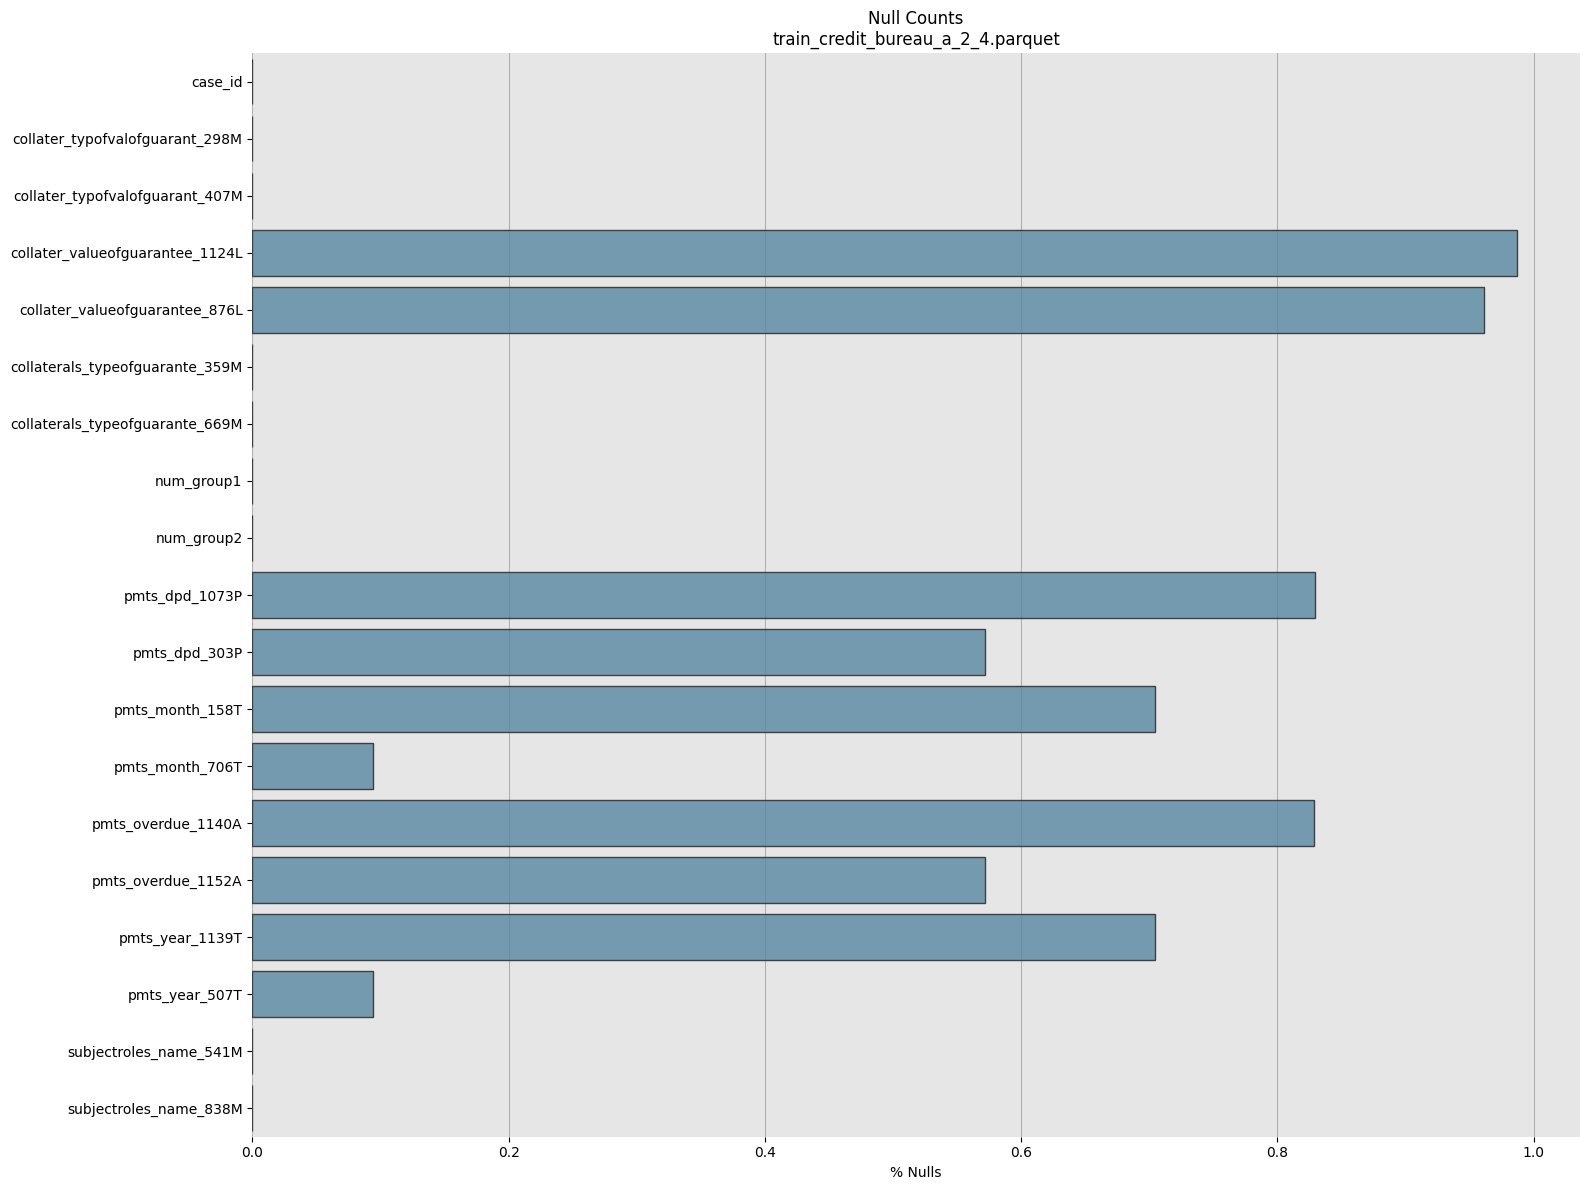

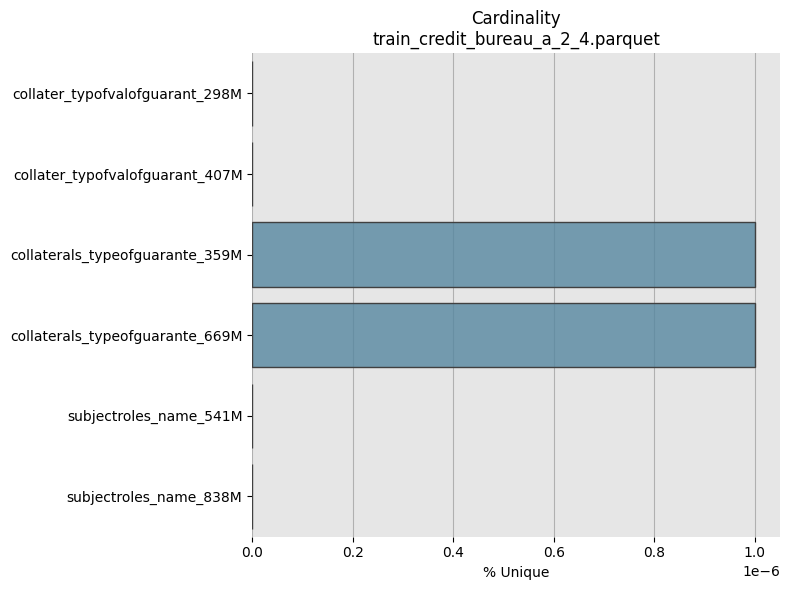

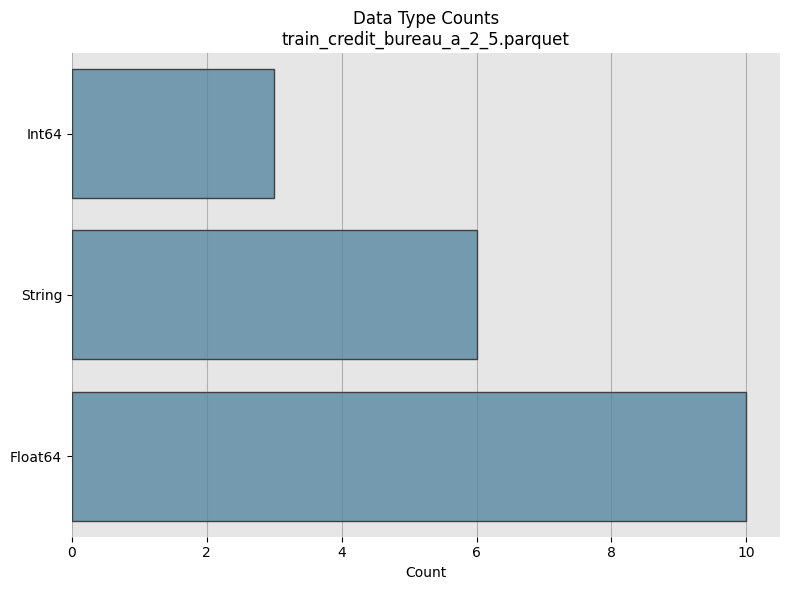

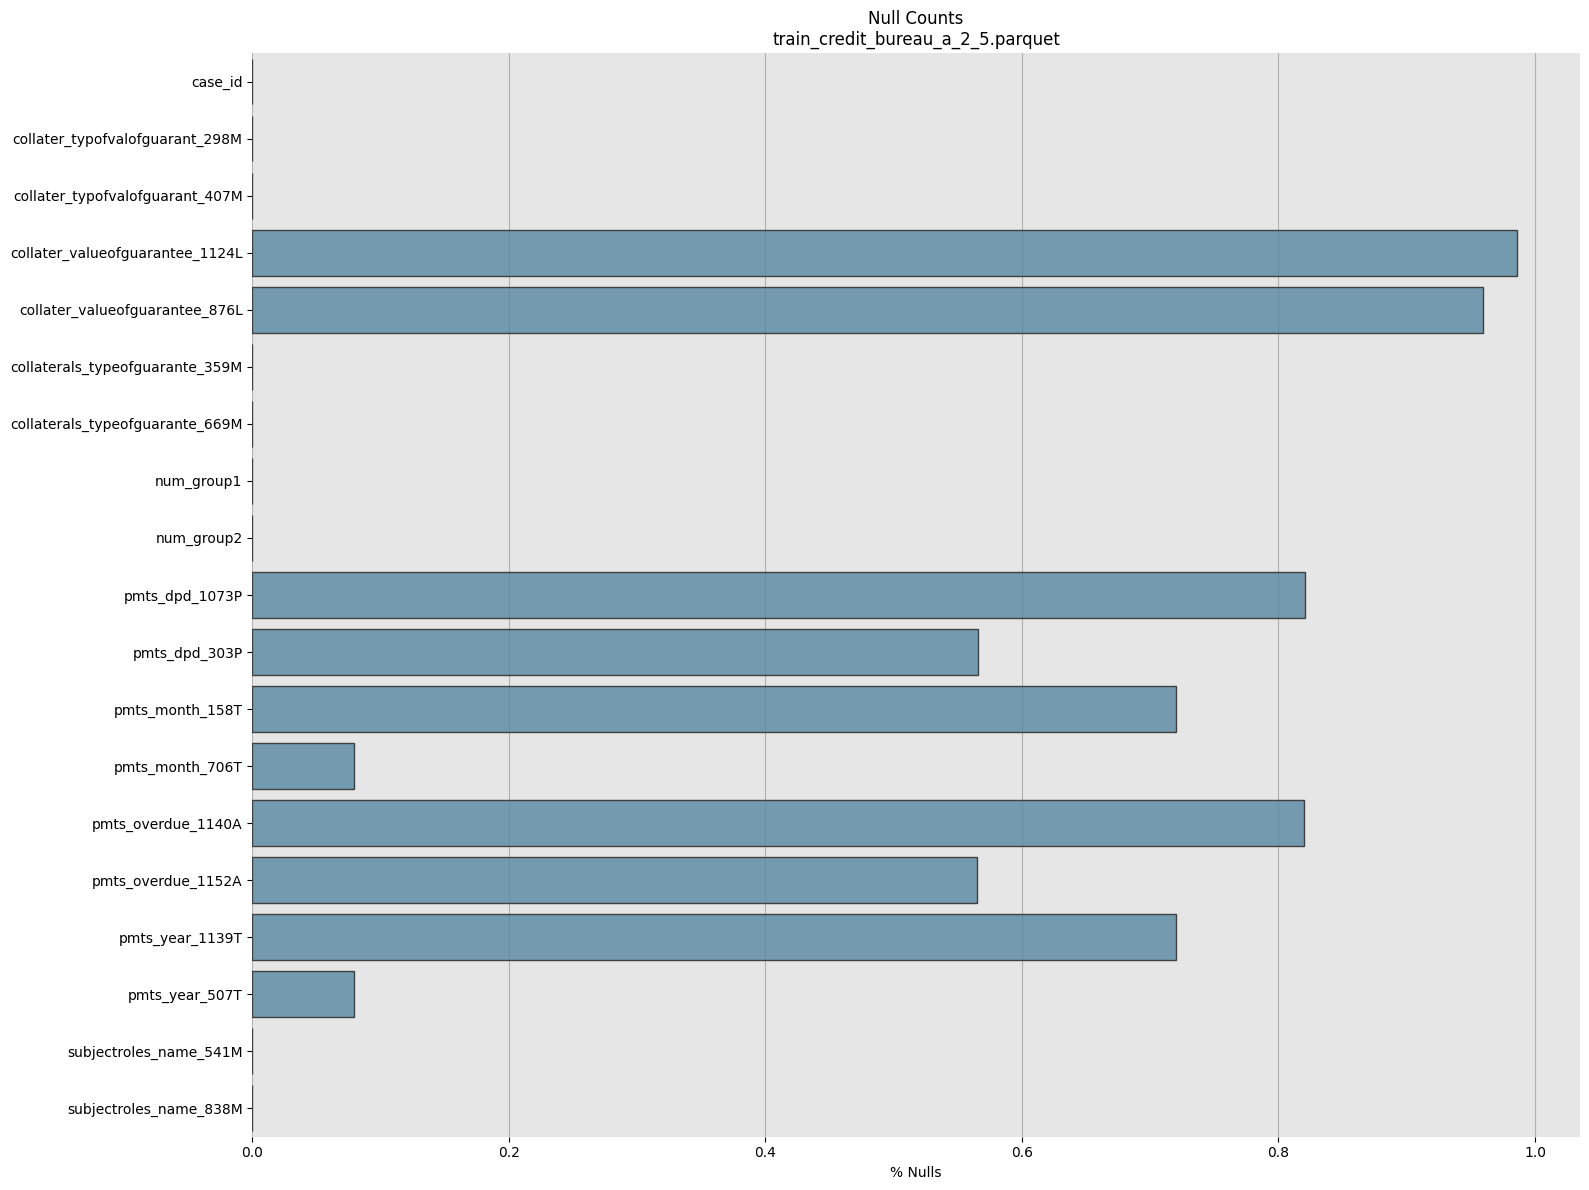

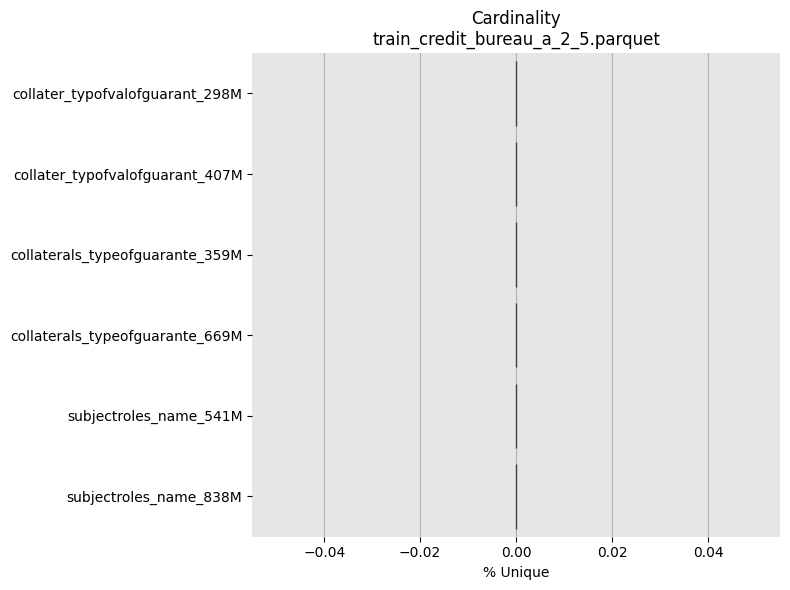

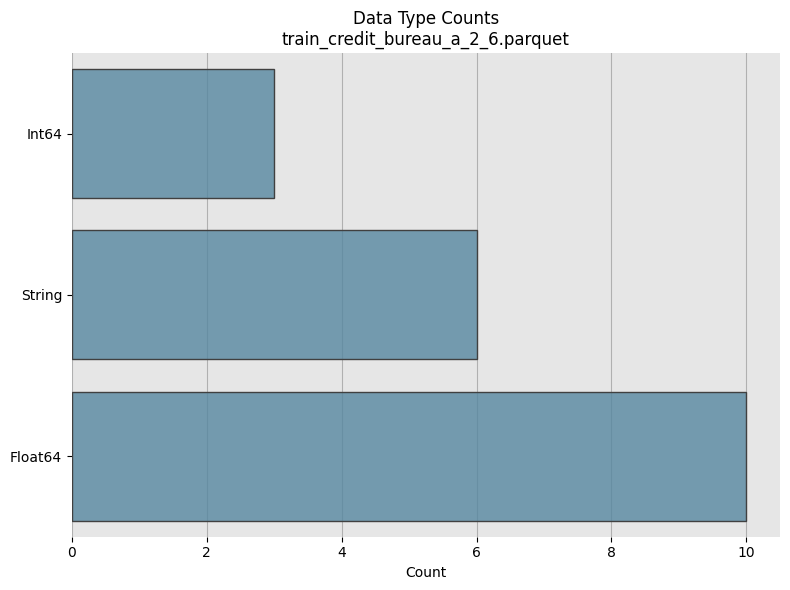

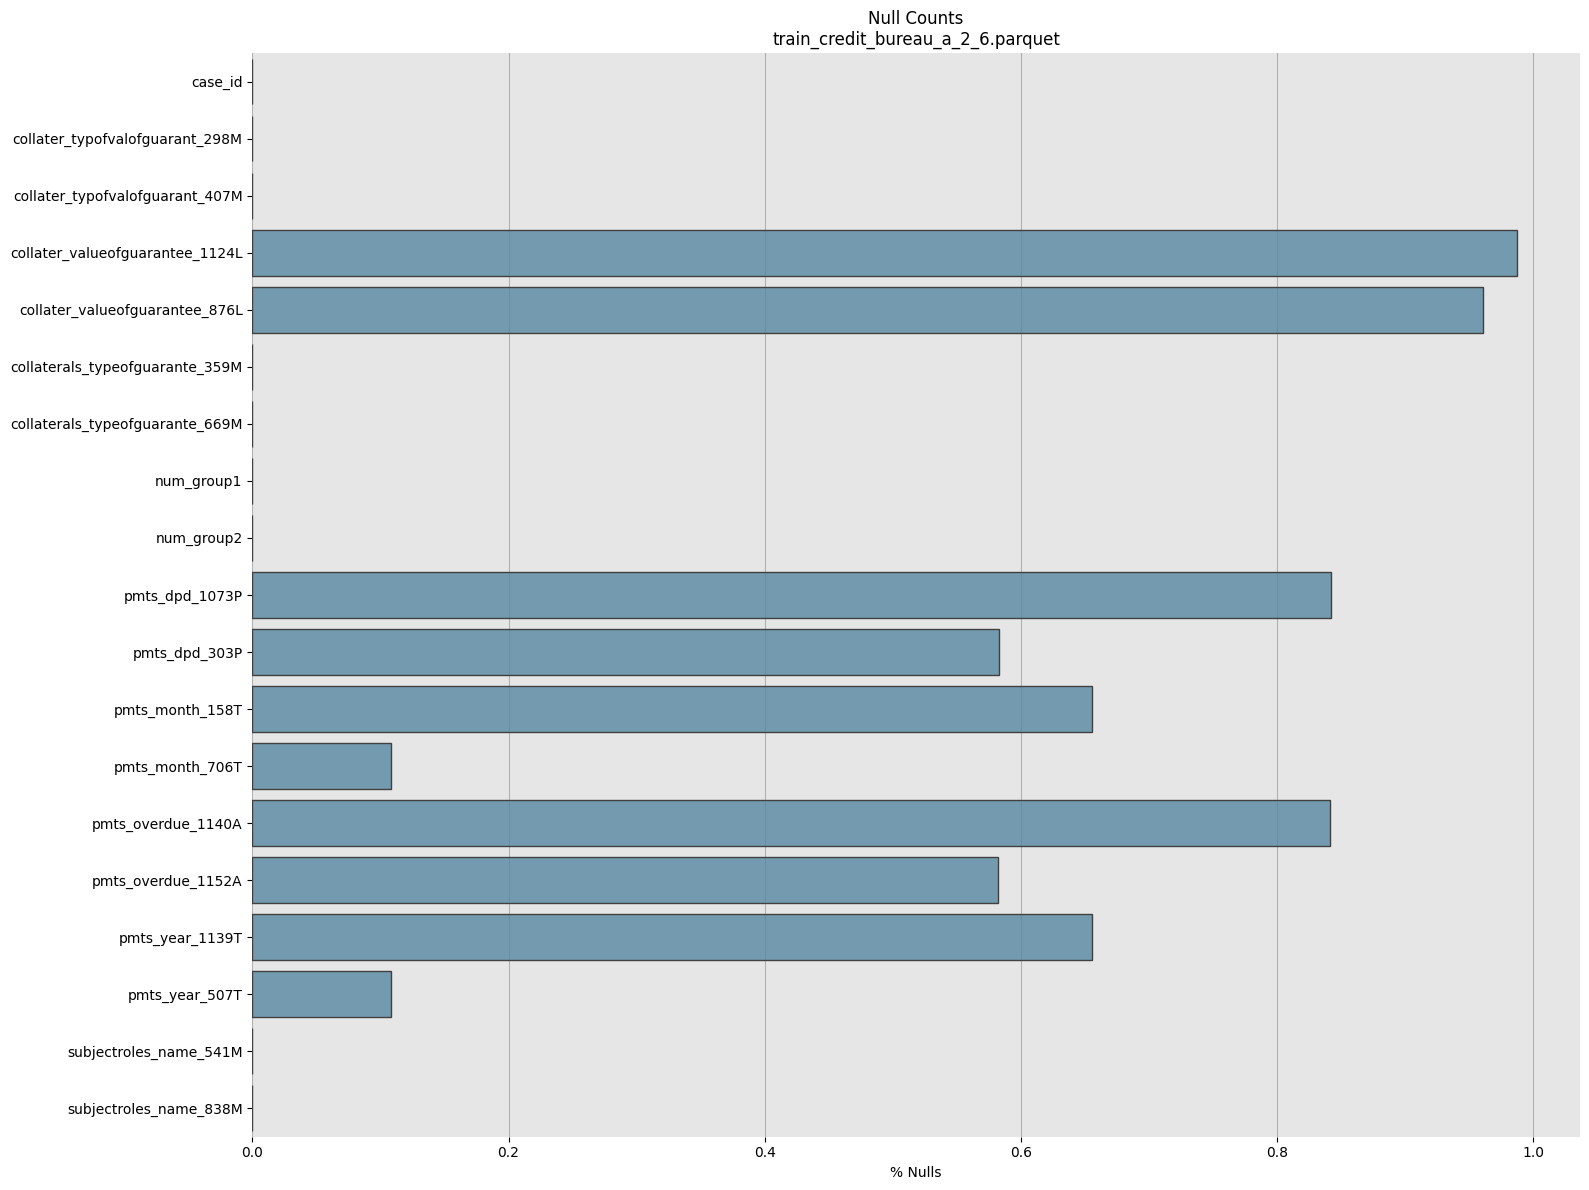

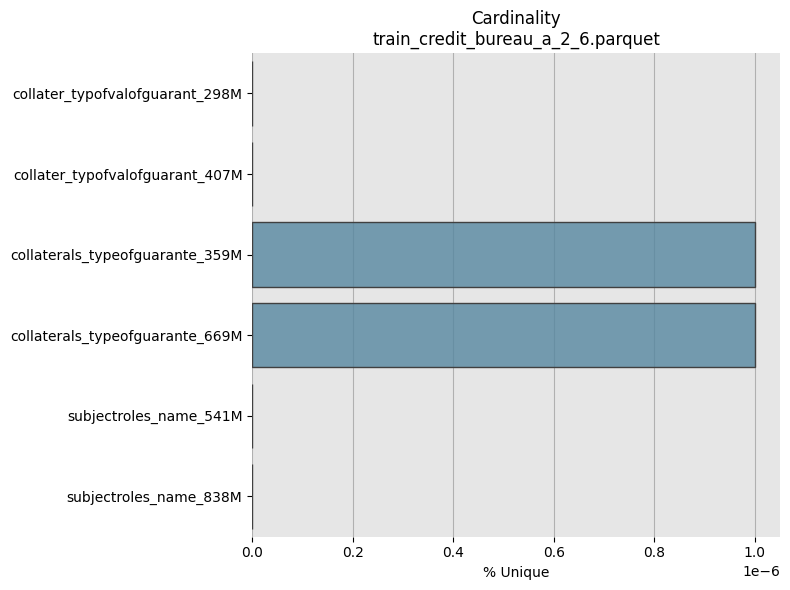

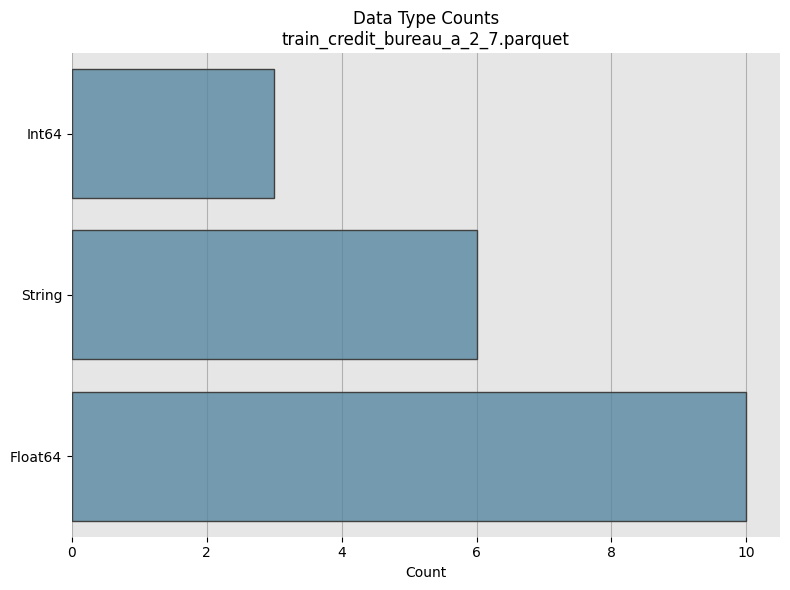

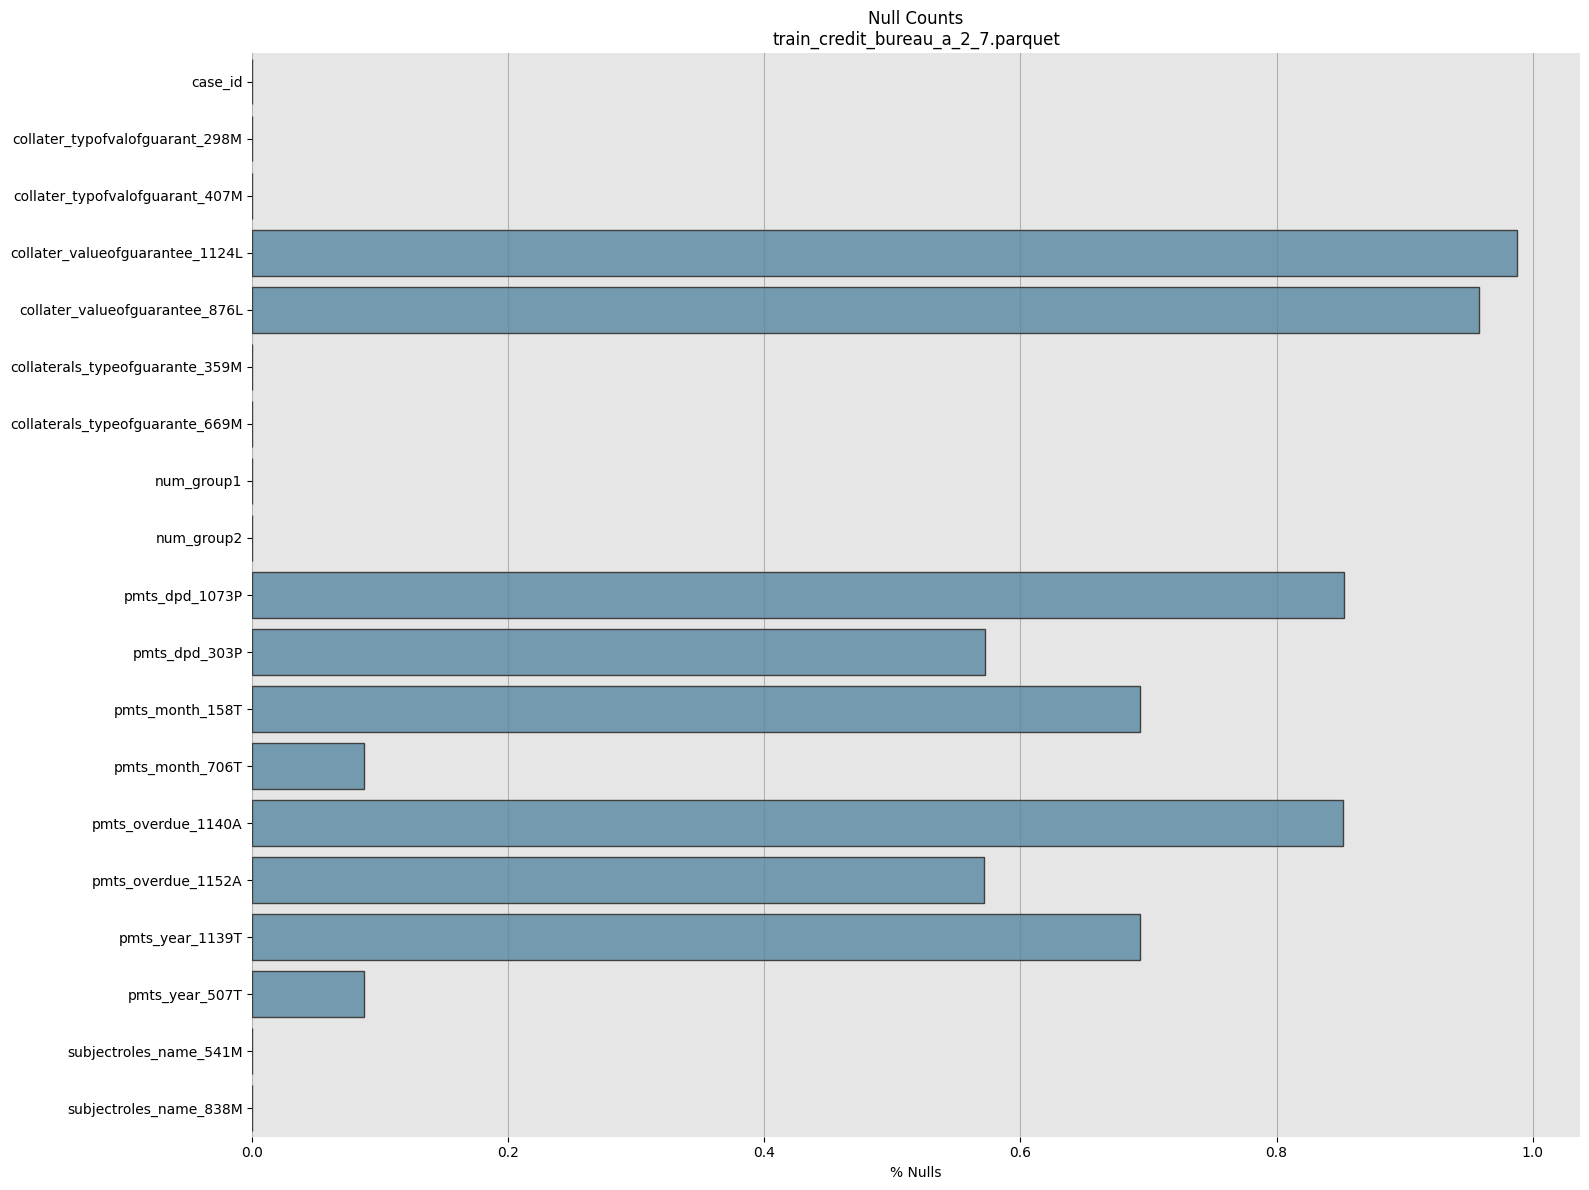

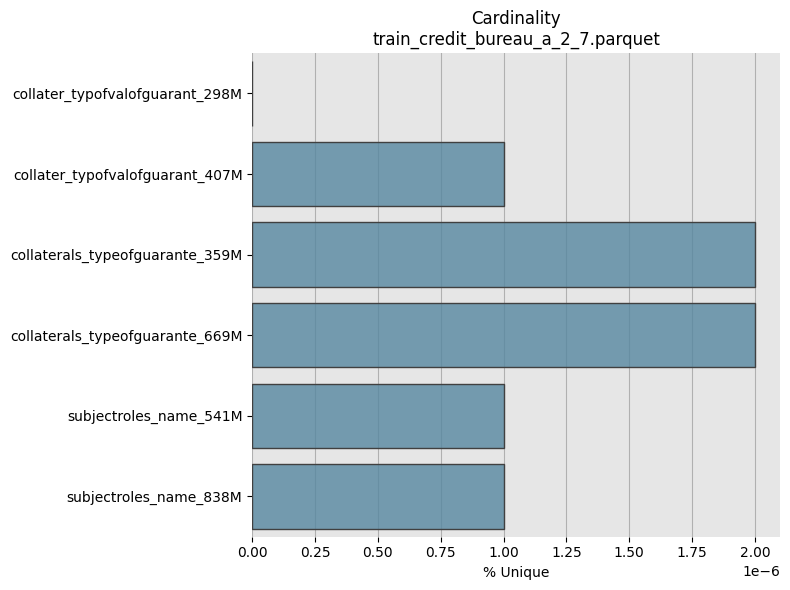

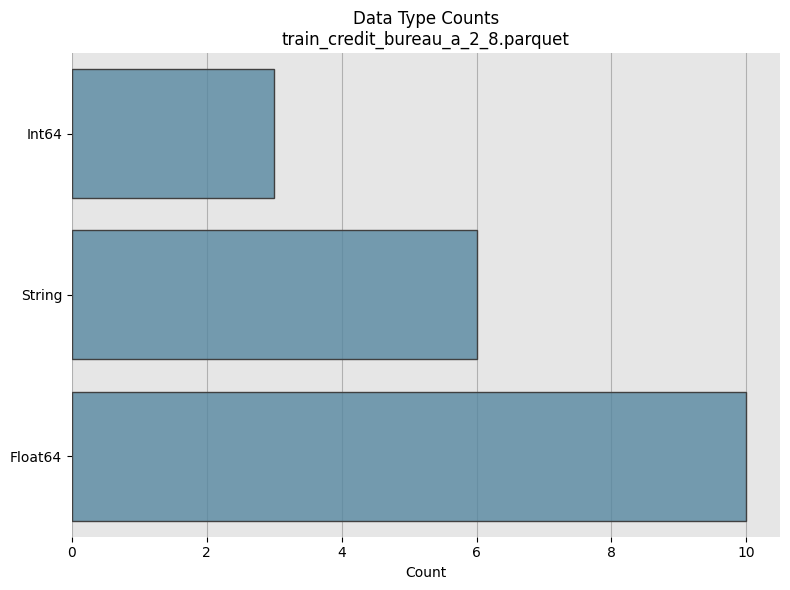

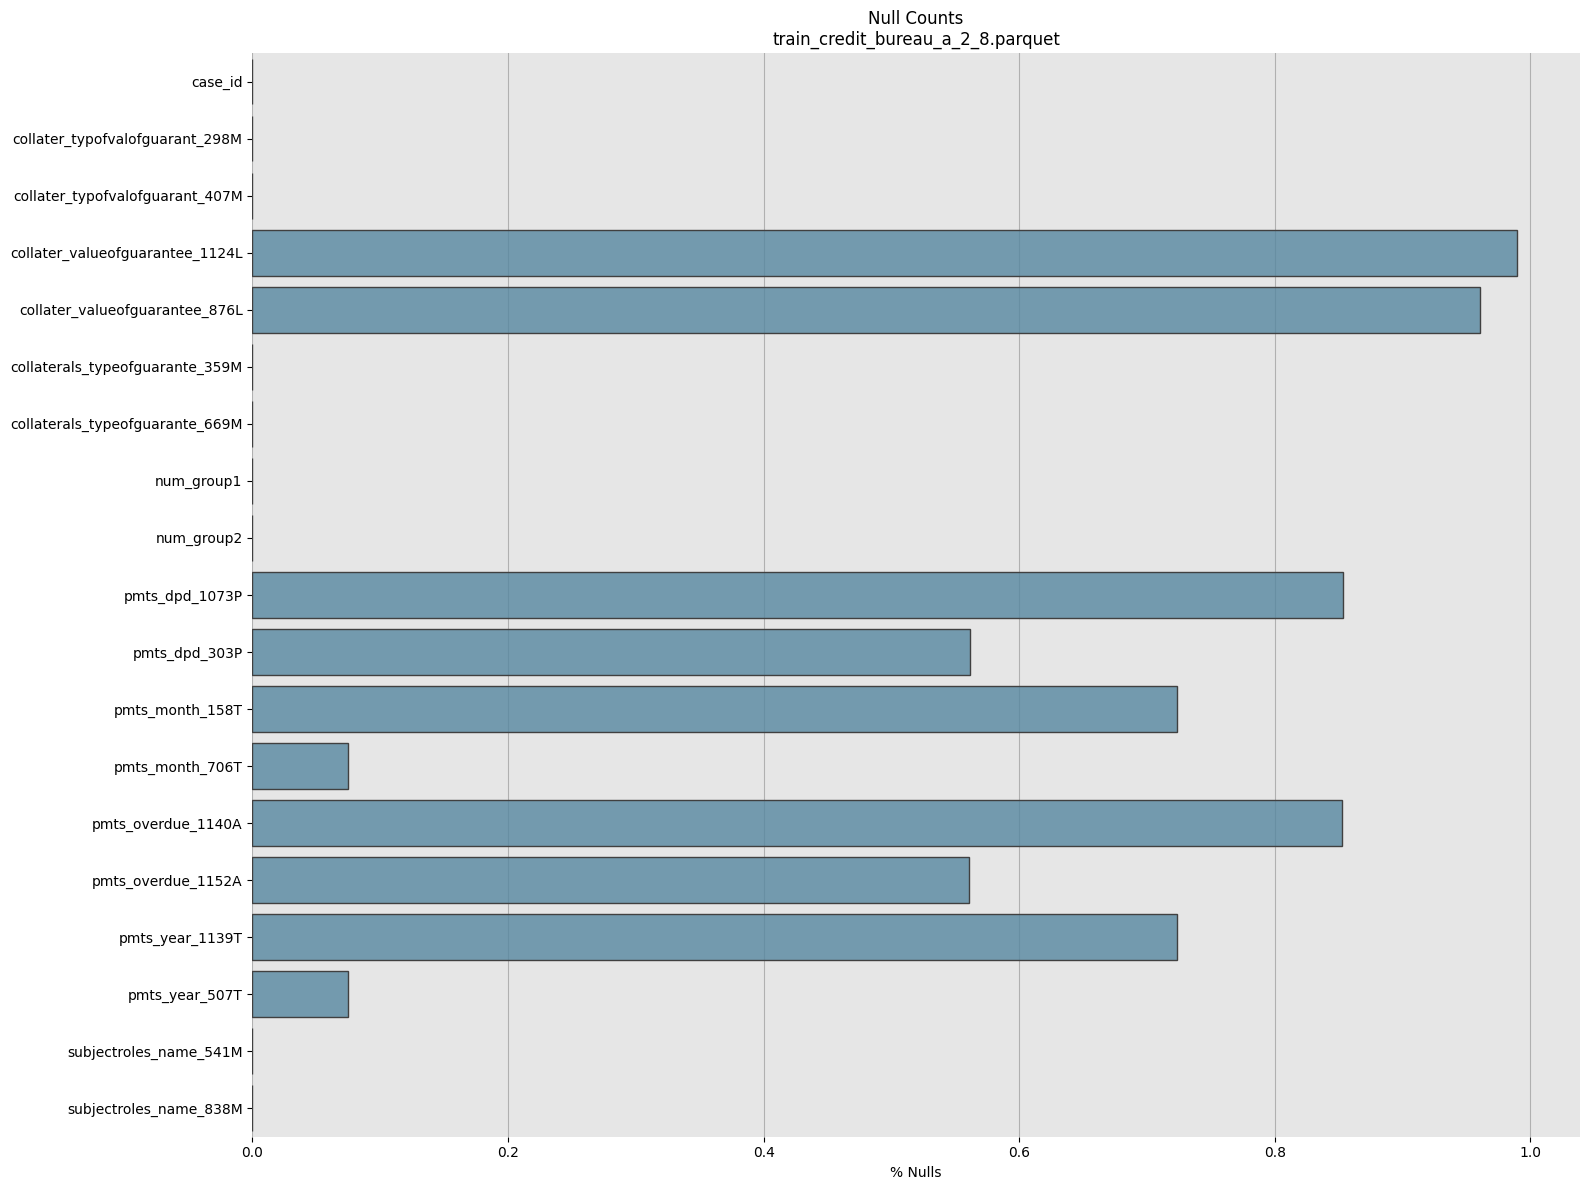

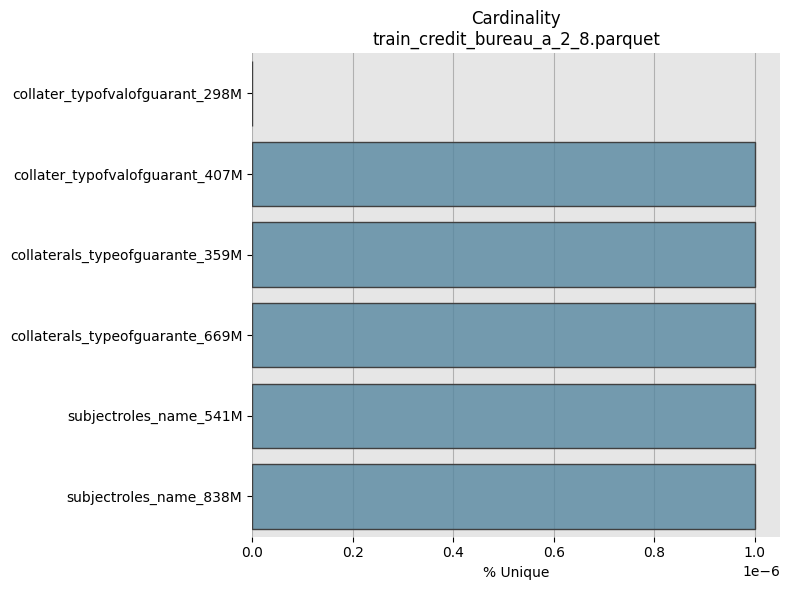

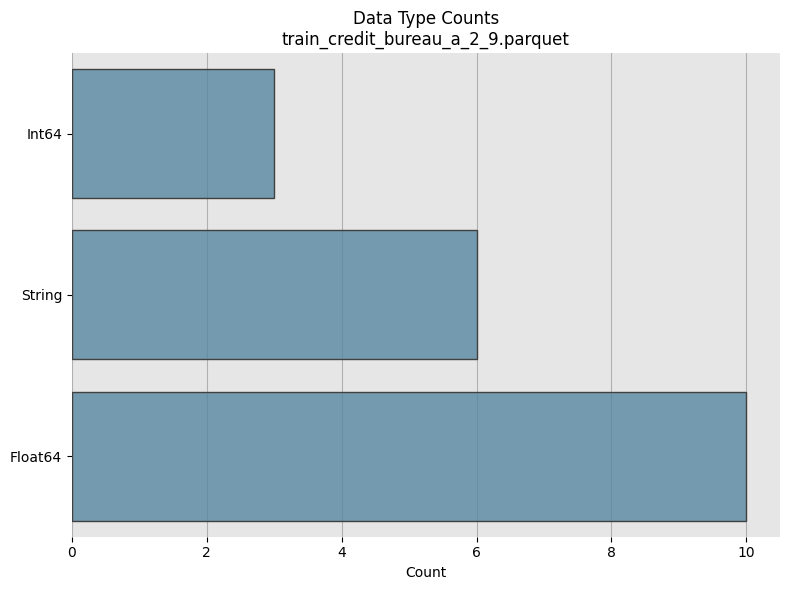

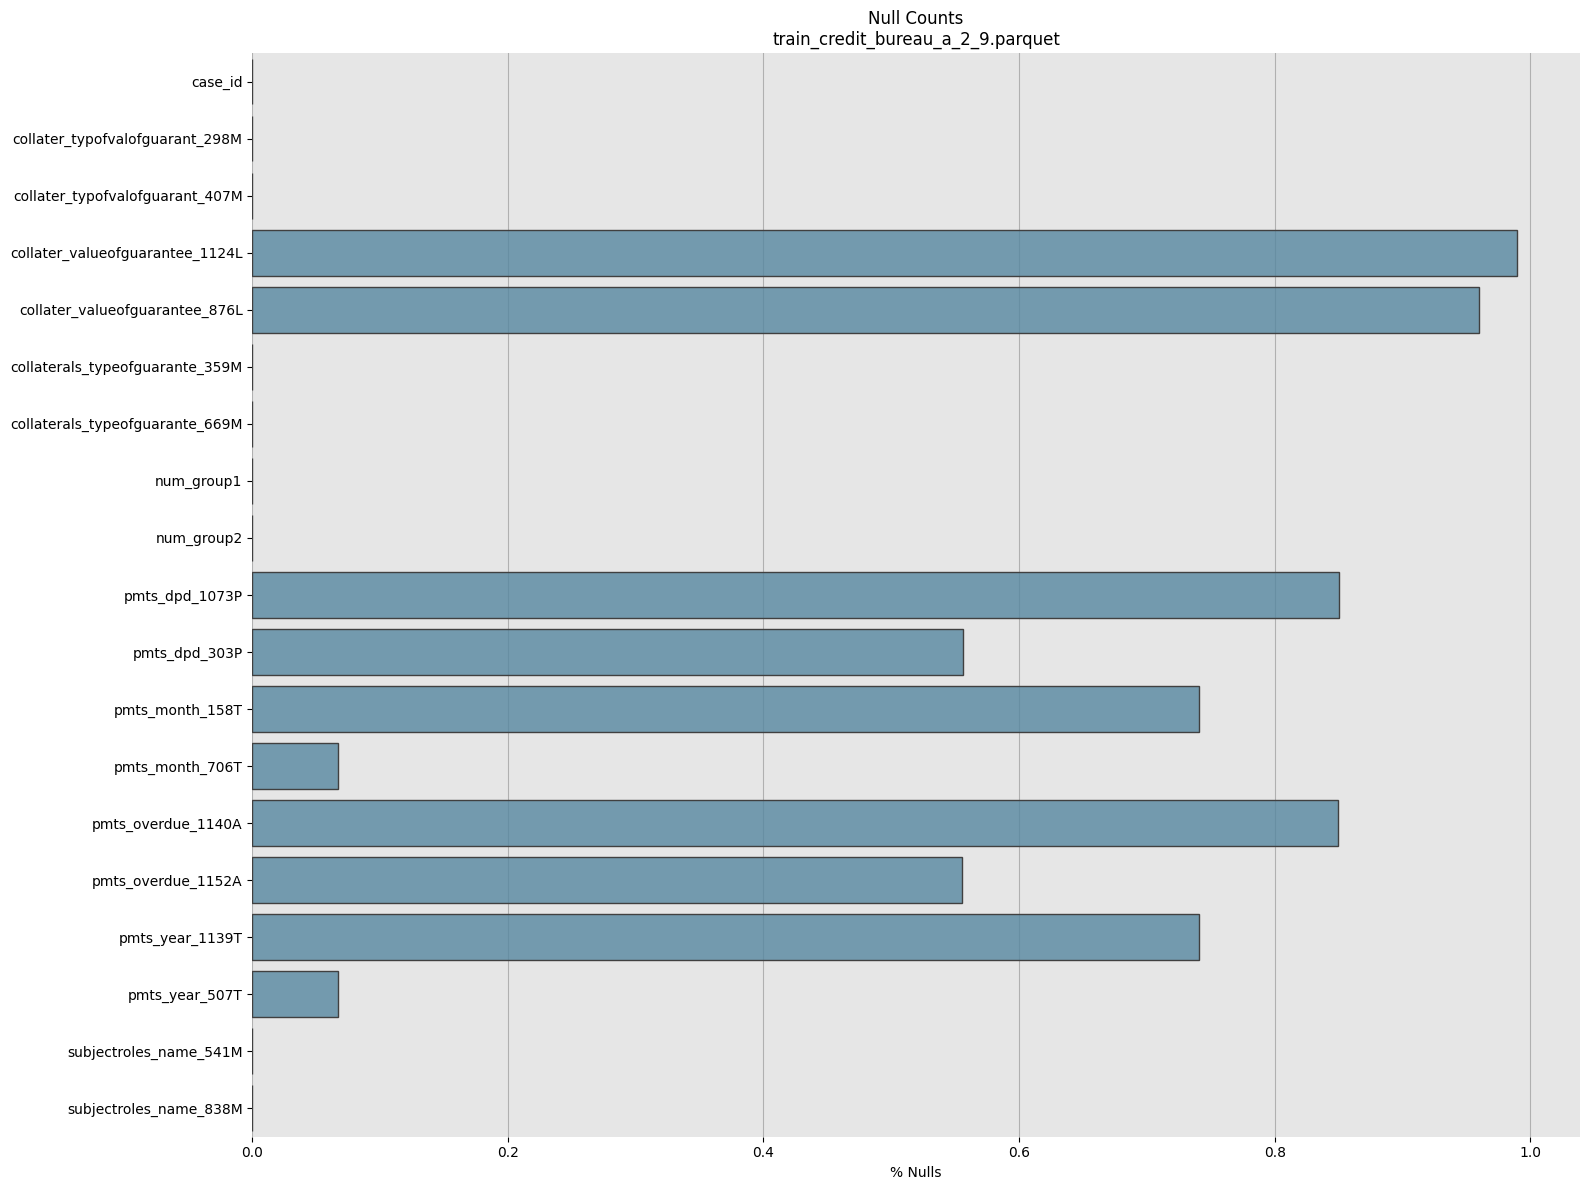

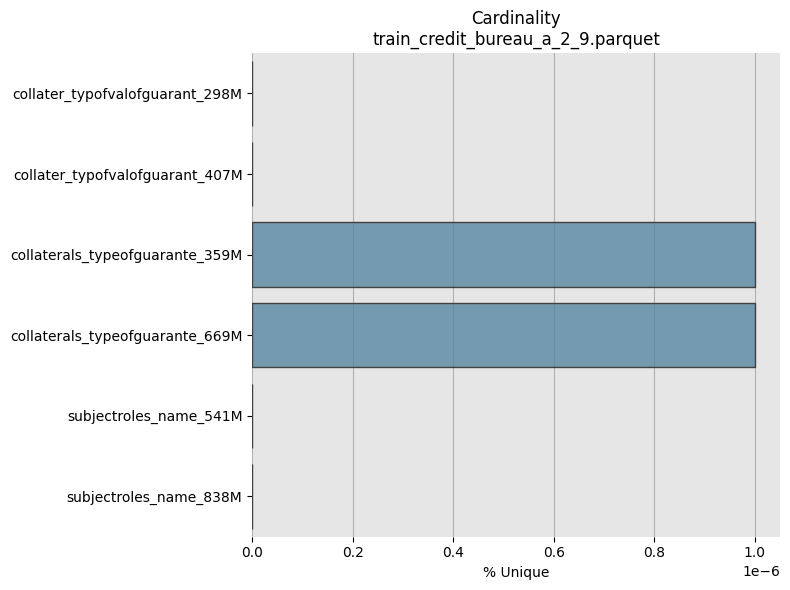

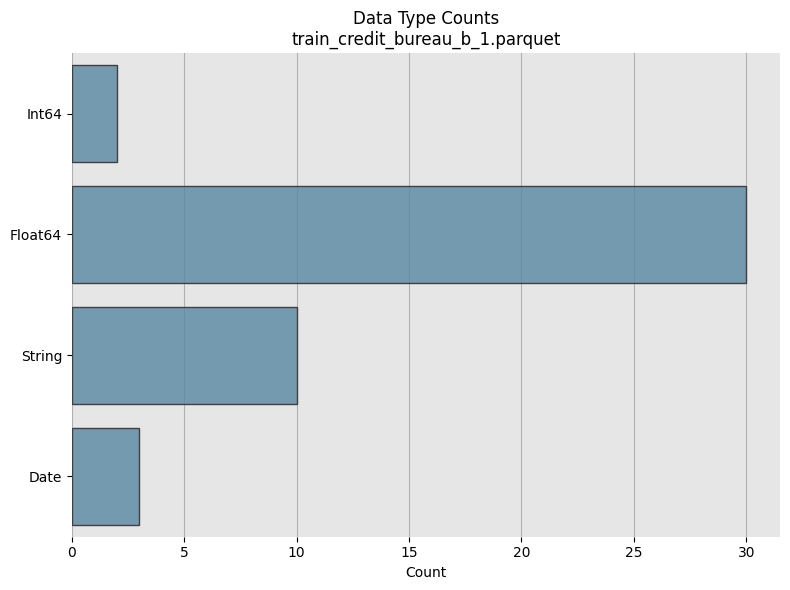

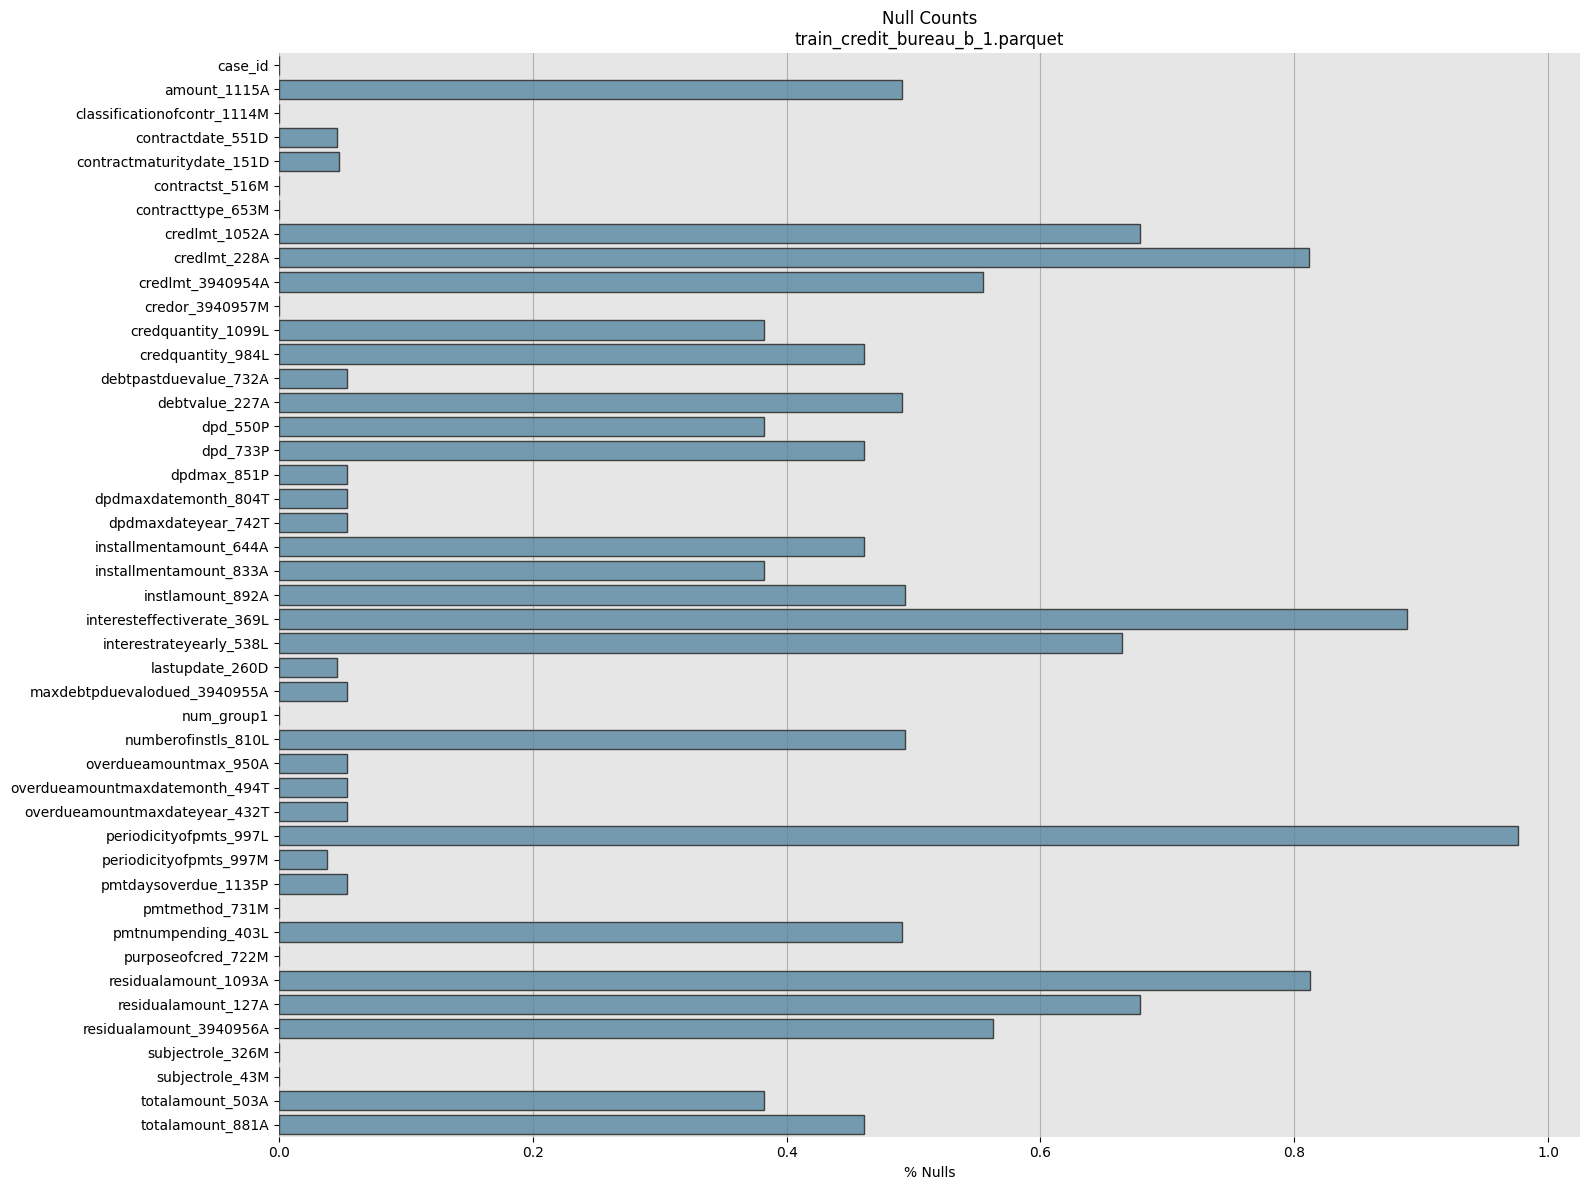

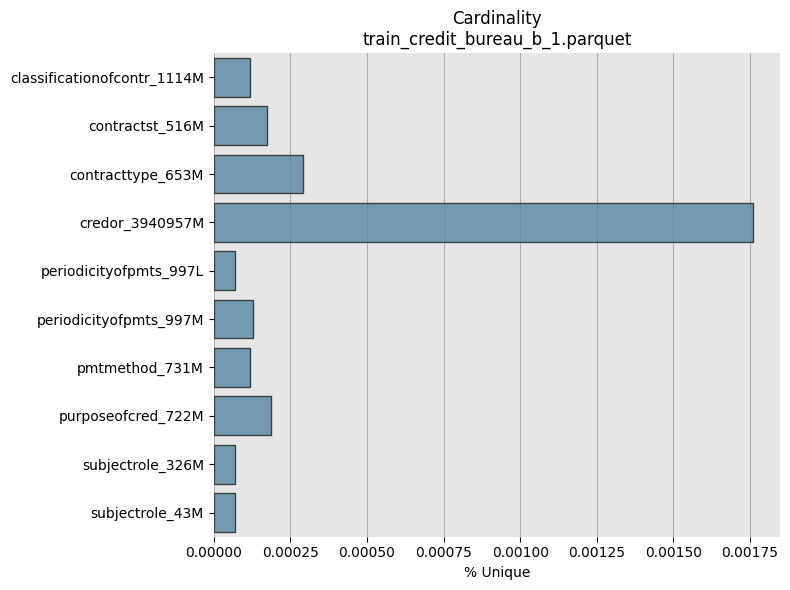

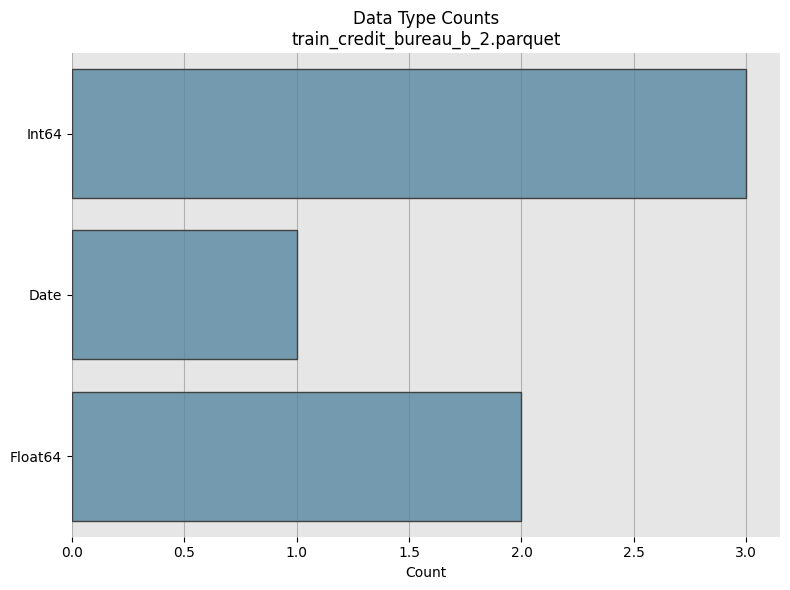

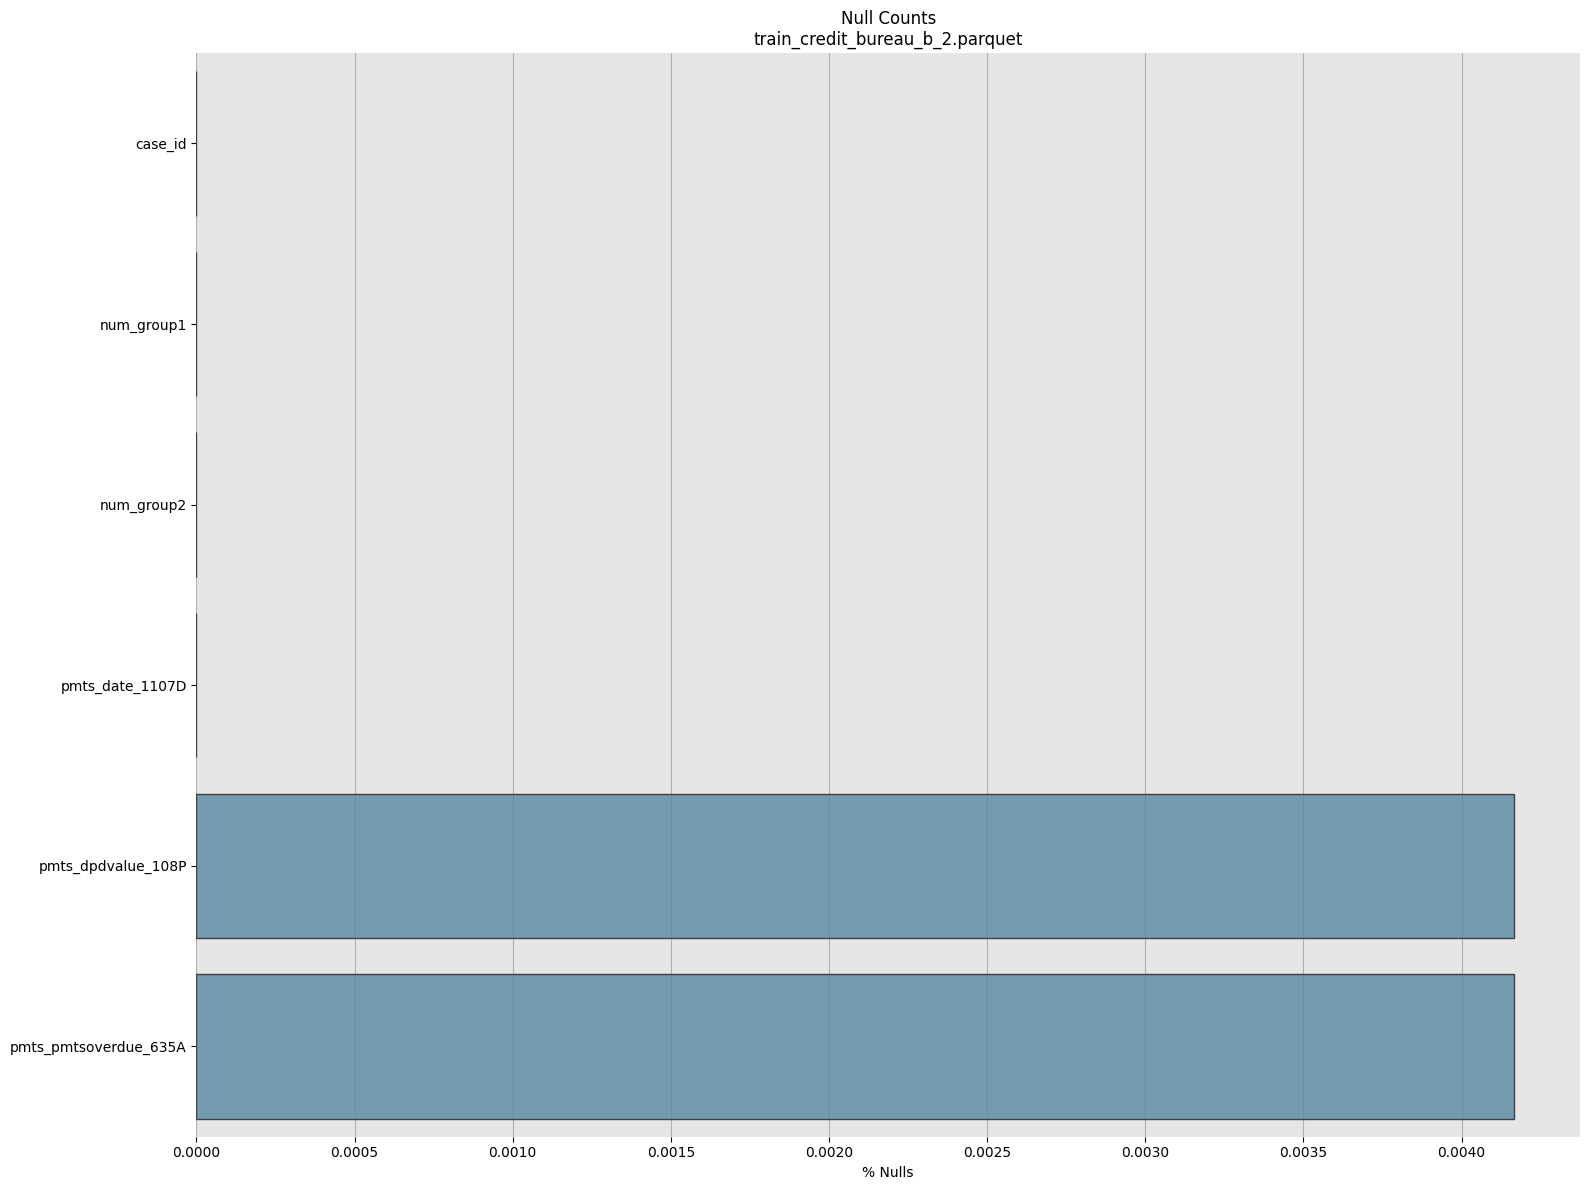

C:\Users\smouz\.conda\envs\isye6740\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


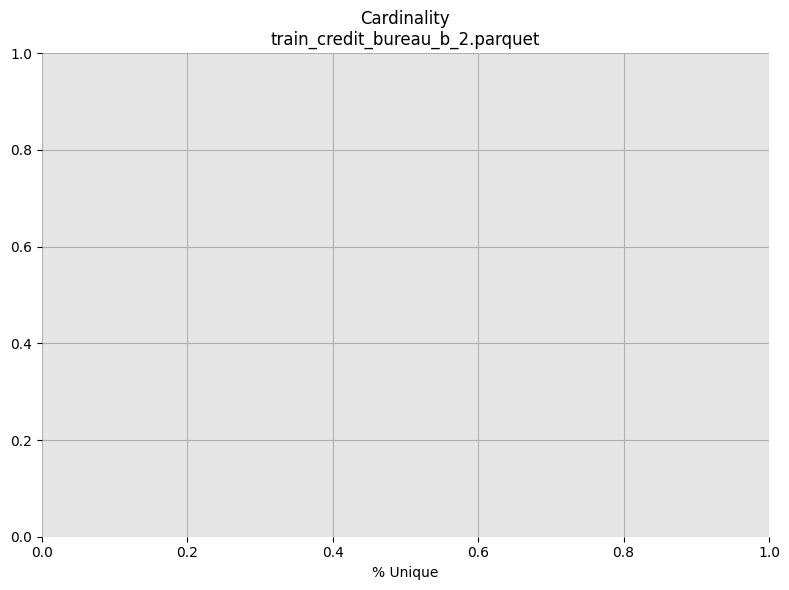

In [9]:
for filename in TRAIN_DIR.glob("*credit_bureau*parquet"):
    df = pl.read_parquet(filename).pipe(Pipeline.set_table_dtypes)
    plot_dtype_count(df, filename)
    plot_nulls(df, filename)
    plot_cardinality(df, filename)
    del df
    gc.collect()

## Nulls

In [10]:
# params = {'legend.fontsize': 'x-large',
#           # 'figure.figsize': (15, 5),
#          'axes.labelsize': 'small',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'small',
#          'ytick.labelsize':'small'}
# plt.rcParams.update(params)

In [11]:
# null_proportion = df.null_count() / df.shape[0]
# null_proportion = null_proportion.to_pandas().T[0]

# fig, ax = plt.subplots(figsize=(16, 12))
# sns.barplot(
#     null_proportion, 
#     orient='h', 
#     # color='blue', 
#     ax=ax,
#     linewidth=1.0,
#     edgecolor="0.25",
#     facecolor=(0.42, 0.42, 0.80, 0.5),
# )
# # ax.bar_label(ax.containers[0], fontsize=7)
# plt.title(f"Null Counts\n{filename.name}")
# plt.xlabel("% Nulls")
# plt.tight_layout()
# plt.show()